
<!---
![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=GoogleCloudPlatform%2Fbigquery_ml_utils%2Fnotebooks&dt=bqml-feature-engineering.ipynb)
-->


---

## Version 2

DEPRICATED 

Find the end result in two new notebooks:
- [BQML Feature Engineering - Create Model With Transpose](../../03%20-%20BigQuery%20ML%20(BQML)/BQML%20Feature%20Engineering%20-%20Create%20Model%20With%20Transpose.ipynb)
- [BQML Feature Engineering - preprocessing functions](../../03%20-%20BigQuery%20ML%20(BQML)/BQML%20Feature%20Engineering%20-%20preprocessing%20functions.ipynb)

---

# BigQuery ML (BQML) - Advanced Feature Engineering

This notebook will explore preparing data (preprocessing) for machine learning with BigQuery using functions that are part of BigQuery ML (BQML). 

This content will accompany the blog post - TBD

>A previous version of this notebook accompanies the blog [How to use advance feature engineering to preprocess data in BigQuery ML](https://cloud.google.com/blog/products/data-analytics/preprocess-data-use-bigquery-ml):

---

**BigQuery ML (BQML)**

BigQuery Machine Learning allows you to use `SQL` to constuct an ML workflow.  This is a great leap in productivity and flexibility when the data source is BigQuery and users are already familiar with `SQL`. Using just `SQL` multiple techniques can be used for model training and even include hyperparameter tuning.  Predictions can be served directly in BigQuery which also include explainability. Models can be registered to Vertex AI model registry for online predictions on Vertex AI Endpoints.

**If you know:**
```SQL
CREATE TABLE {table name}
    AS
        SELECT ...
        FROM ...
        WHERE ...
```

**Then you are ready to try:**
```SQL
CREATE MODEL {model name} 
    OPTIONS (
        MODEL_TYPE = ...
        {more options}
    )
    AS
        SELECT ...
        FROM ...
        WHERE ...
```

**You can even use:**
```SQL
CREATE OR REPLACE MODEL {model name}...
```

And

```SQL
CREATE MODEL IF NOT EXISTS {model name}...
```

**Functions for your ML Workflow**

Model Evaluation with `ML.EVALUTE`:
```SQL
SELECT *
FROM ML.EVALUTE(
    MODEL {model name},
    (
        SELECT ...
        FROM ...
        WHERE ...),
    STRUCT({optional parameters})
)
```

Prediction Using Models with `ML.PREDICT`:
```SQL
SELECT *
FROM ML.PREDICT(
    MODEL {model name},
    (
        SELECT ...
        FROM ...
        WHERE ...),
    STRUCT({optional parameters})
)
```

---

**Feature Engineering**

Feature engineering, or [preprocessing](https://cloud.google.com/bigquery/docs/preprocess-overview), is part of making data ready for machine learning.  BigQuery ML [manual feature preprocessing](https://cloud.google.com/bigquery/docs/manual-preprocessing) functions are available to make this process simple within BigQuery.  

Each `CREATE MODEL ...` statement will do [automatic feature preprocessing](https://cloud.google.com/bigquery/docs/auto-preprocessing) by default.  It is also possible include manual feature preprocessing in the `CREATE MODEL ...` statement as a `TRANSFORM` clause where it will also become part of the model serving.  Some of these functions even accompany the model when [exporting from BigQuery](https://cloud.google.com/bigquery/docs/exporting-models) and [directly registered to Vertex AI Model Registry](https://cloud.google.com/bigquery/docs/create_vertex).

```SQL
CREATE MODEL {model name} AS
    TRANSFORM (
        ML.{function name}() OVER() as {name},
        ...
    )
    OPTIONS (
        MODEL_TYPE = ...
        {more options}
    )
    AS
        SELECT ...
        FROM ...
        WHERE ...
```
  
---

**Getting Started**
<p align="center" width="100%">
A great place to start exploring what model types are available and the functions to help create an ML workflow with each model type is this site:
    <center>
        <span style="font-size:xx-large;">
        <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey">
            End-to-end user journey for each model
        </a>
        </span>
    </center>

Another great resourse for getting started is the "What is BigQuery ML?" starting page which include a model selection guide.
    <center>
        <span style="font-size:xx-large;">
        <a href="https://cloud.google.com/bigquery-ml/docs/introduction">
        What is BigQuery ML?
        </a>
        </span>
    </center>
</p>

---

**Prerequisites:**

None

**Services Used:**
- BigQuery
- Vertex AI: Workbench (this notebook), Model Registry, Endpoints
- GCS

**Resources:**
- [BigQuery ML (BQML) Overview](https://cloud.google.com/bigquery-ml/docs/introduction)
- [Overview of BQML methods and workflows](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey)
- [BigQuery](https://cloud.google.com/bigquery)
    - [Documentation:](https://cloud.google.com/bigquery/docs/query-overview)
    - [API:](https://cloud.google.com/bigquery/docs/reference/libraries-overview)
        - [Clients](https://cloud.google.com/bigquery/docs/reference/libraries)
            - [Python SDK:](https://github.com/googleapis/python-bigquery)
            - [Python Library Reference:](https://cloud.google.com/python/docs/reference/bigquery/latest)

---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GoogleCloudPlatform/bigquery-ml-utils/blob/master/notebooks/bqml-feature-engineering.ipynb) and run the cells in this section.  Otherwise, skip this section.

In [475]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

Updated property [core/project].


In [473]:
try:
    import google.colab
    !pip install --upgrade google-cloud-aiplatform -q
    !pip install --upgrade gcsfs -q
    !pip install --upgrade google-cloud-bigquery -q
    !pip install --upgrade google-cloud-bigquery-storage -q
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

The Next cell will restart the runtime by first stopping it and then Colab will automatically restart - you may need to dismiss a popup warning letting you know about this unexpected restart.  This restart makes the installs above available to the current session.

In [474]:
try:
    import google.colab
    import os
    os.kill(os.getpid(), 9)
except Exception:
    pass

---
## Environment Setup

inputs:

In [7]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [8]:
REGION = 'us-central1'
EXPERIMENT = 'feature_engineering'
SERIES = '03'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'feature_engineering'
BQ_TABLE = 'bread'

packages:

In [9]:
from google.cloud import aiplatform
from google.cloud import bigquery
from google.cloud import storage

from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import pandas as pd
import json

from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value

clients:

In [10]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bq = bigquery.Client(project=PROJECT_ID, location = 'US')
gcs = storage.Client(project = PROJECT_ID)

environment:

In [11]:
DIR = f"temp/{EXPERIMENT}"
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Step 1: Transform BigQuery columns into ML features with SQL

BigQuery ML [feature preprocessing functions](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-bucketize) are usefull for converting BigQuery columns to ML features.  BigQuery ML has included a set of these for manual preprocessing and they are individually demonstrated here.

These functions can be used directly in BigQuery SQL or within the [`TRANSFORM` clause](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform) of the [`CREATE MODEL` statement](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#create_model_syntax).  Using these inside of the `TRANSFORM` clause means they will also be automatically applied during model serving in BigQuery with `ML.PREDICT`.  Some preprocessing statments can also accompany [exported models](https://cloud.google.com/bigquery/docs/exporting-models) and models [directly registered to Vertex AI Model Registry](https://cloud.google.com/bigquery/docs/create_vertex).

**NOTE:** Some of the functions require using calculations over all values in the column and make use of an empty `OVER()` clause.  See `ML.QUANTILE_BUCKETIZE`, `ML.MIN_MAX_SCALER`, `ML.STANDARD_SCALER` for examples. 


### General Functions

[General functions](https://cloud.google.com/bigquery/docs/manual-preprocessing#general_functions) for data cleanup of string or numberical expressions.  Currently, this include the ML.IMPUTER function for imputing missing values.

#### ML.IMPUTER

Given a column, numerical or categorical (string), the function replaces `NULL` values with the value specified by the paramter `strategy`.
- `expression` is numerical or categorial input
- `strategy` is a string value that specifies how to replace `NULL` values:
    - 'mean' uses the mean (only for numerical columns)
    - 'median' uses the median (only for numerical columns)
    - 'most_frequent' uses the mode
- [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-imputer)
- Is [exportable](https://cloud.google.com/bigquery/docs/exporting-models#export-transform-functions) when used in [`TRANFORM` clause](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform).

In [12]:
query = f"""
    SELECT
        num_column,
        ML.IMPUTER(num_column, 'mean') OVER() AS num_imputed_mean,
        ML.IMPUTER(num_column, 'median') OVER() AS num_imputed_median,
        ML.IMPUTER(num_column, 'most_frequent') OVER() AS num_imputed_mode,
        string_column,
        ML.IMPUTER(string_column, 'most_frequent') OVER() AS string_imputed_mode,
    FROM
        UNNEST([1, 1, 2, 3, 4, 5, NULL]) AS num_column WITH OFFSET pos1,
        UNNEST(['a', 'a', 'b', 'c', 'd', 'e', NULL]) AS string_column WITH OFFSET pos2
    WHERE pos1 = pos2
    ORDER BY num_column
"""
print(query)


    SELECT
        num_column,
        ML.IMPUTER(num_column, 'mean') OVER() AS num_imputed_mean,
        ML.IMPUTER(num_column, 'median') OVER() AS num_imputed_median,
        ML.IMPUTER(num_column, 'most_frequent') OVER() AS num_imputed_mode,
        string_column,
        ML.IMPUTER(string_column, 'most_frequent') OVER() AS string_imputed_mode,
    FROM
        UNNEST([1, 1, 2, 3, 4, 5, NULL]) AS num_column WITH OFFSET pos1,
        UNNEST(['a', 'a', 'b', 'c', 'd', 'e', NULL]) AS string_column WITH OFFSET pos2
    WHERE pos1 = pos2
    ORDER BY num_column



In [13]:
df = bq.query(query = query).to_dataframe()
df

num_column  num_imputed_mean  num_imputed_median  num_imputed_mode  \
0        <NA>          2.666667                 2.0               1.0   
1           1          1.000000                 1.0               1.0   
2           1          1.000000                 1.0               1.0   
3           2          2.000000                 2.0               2.0   
4           3          3.000000                 3.0               3.0   
5           4          4.000000                 4.0               4.0   
6           5          5.000000                 5.0               5.0   

  string_column string_imputed_mode  
0          None                   a  
1             a                   a  
2             a                   a  
3             b                   b  
4             c                   c  
5             d                   d  
6             e                   e

### Categorical Functions

[Categorical functions](https://cloud.google.com/bigquery/docs/manual-preprocessing#categorical_functions) for categorizing data with string expressions.

#### ML.FEATURE_CROSS

Given a STRUCT of categorial features this returns a STRUCT of all combinations up to the degree passed-in (default = 2).
- `struct_categorical_features` is a STRUCT of string values for categorical features column names to cross
- `degree` (optional) is the highest degree of feature combinations to create
    - in the range of [2, 4] with default = 2
- [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-feature-cross)
- Is not [exportable](https://cloud.google.com/bigquery/docs/exporting-models#export-transform-functions) when used in [`TRANFORM` clause](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform).

In [12]:
query = f"""
    SELECT
        input_column_1, input_column_2, input_column_3,
        ML.FEATURE_CROSS(STRUCT(input_column_1, input_column_2, input_column_3)) AS feature_column
    FROM
        UNNEST(['a', 'b', 'c']) as input_column_1 WITH OFFSET pos1,
        UNNEST(['A', 'B', 'C']) AS input_column_2 WITH OFFSET pos2,
        UNNEST(['1', '2', '3']) AS input_column_3 WITH OFFSET pos3
    WHERE
        pos1 = pos2 AND pos2 = pos3
"""
print(query)


    SELECT
        input_column_1, input_column_2, input_column_3,
        ML.FEATURE_CROSS(STRUCT(input_column_1, input_column_2, input_column_3)) AS feature_column
    FROM
        UNNEST(['a', 'b', 'c']) as input_column_1 WITH OFFSET pos1,
        UNNEST(['A', 'B', 'C']) AS input_column_2 WITH OFFSET pos2,
        UNNEST(['1', '2', '3']) AS input_column_3 WITH OFFSET pos3
    WHERE
        pos1 = pos2 AND pos2 = pos3



In [13]:
df = bq.query(query = query).to_dataframe()
df

input_column_1 input_column_2 input_column_3  \
0              a              A              1   
1              b              B              2   
2              c              C              3   

                                      feature_column  
0  {'input_column_1_input_column_2': 'a_A', 'inpu...  
1  {'input_column_1_input_column_2': 'b_B', 'inpu...  
2  {'input_column_1_input_column_2': 'c_C', 'inpu...

In [14]:
df['feature_column'].iloc[-1]

{'input_column_1_input_column_2': 'c_C',
 'input_column_1_input_column_3': 'c_3',
 'input_column_2_input_column_3': 'C_3'}

#### ML.HASH_BUCKATIZE

Given a column of string values this function will hash the values as a new column.  If a bucket size > 0 provided it will take the mod of the hash: remainder of the hash divided by bucket size as the bucket number.
- `string_expression` is the string for the categorical feature to bucketize
- `hash_bucket_size` is an integer for the number of buckets to create
    - if 0, strings are hashed without bucketizing
- [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-hash-bucketize)
- Is [exportable](https://cloud.google.com/bigquery/docs/exporting-models#export-transform-functions) when used in [`TRANFORM` clause](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform).

In [16]:
query = f"""
    SELECT
        input_column,
        ML.HASH_BUCKETIZE(input_column, 0) AS hash_column,
        ML.HASH_BUCKETIZE(input_column, 3) AS feature_column
    FROM
        UNNEST(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']) as input_column
"""
print(query)


    SELECT
        input_column,
        ML.HASH_BUCKETIZE(input_column, 0) AS hash_column,
        ML.HASH_BUCKETIZE(input_column, 3) AS feature_column
    FROM
        UNNEST(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']) as input_column



In [17]:
df = bq.query(query = query).to_dataframe()
df

input_column           hash_column  feature_column
0            a  -5528939962900187677               0
1            b  -6651148003232386794               1
2            c  -7016299626566550744               1
3            d   4470636696479570465               2
4            e  -3078673838733201075               1
5            f  -1522288349254903624               0
6            g   4940667224093463419               2
7            h  -2585402310428948559               1
8            i  -9189916281559197516               1

#### ML.LABEL_ENCODER

Given a string column the function will encode the value as integers [0, n] representing categories.  Any `NULL` or removed values will be encoded with `0`.
- `string_expression` is the string for the catgorical feature to encode
- `top_k` (optional) takes an integer value that specifies the limit on the number of categories to encode based on frequency
    - default is 32,000
    - max is 1 million
- `frequency_threshold` (optional) takes an integer value that specifies that minimum frequency to be encoded. Categories below the threshold are encoded as 0.
    - default = 5
- [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-label-encoder)
- Is [exportable](https://cloud.google.com/bigquery/docs/exporting-models#export-transform-functions) when used in [`TRANFORM` clause](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform).

In [22]:
query = f"""
    SELECT
        input_column,
        ML.LABEL_ENCODER(input_column) OVER() AS labeled_all,
        ML.LABEL_ENCODER(input_column, 3) OVER() AS labeled_top3,
        ML.LABEL_ENCODER(input_column, 3, 3) OVER() AS labeled_top3_min3
    FROM
        UNNEST([NULL, 'a', 'b', 'b', 'c', 'c', 'c', 'd', 'd', 'd', 'd', 'd']) AS input_column
    ORDER BY input_column
"""
print(query)


    SELECT
        input_column,
        ML.LABEL_ENCODER(input_column) OVER() AS labeled_all,
        ML.LABEL_ENCODER(input_column, 3) OVER() AS labeled_top3,
        ML.LABEL_ENCODER(input_column, 3, 3) OVER() AS labeled_top3_min3
    FROM
        UNNEST([NULL, 'a', 'b', 'b', 'c', 'c', 'c', 'd', 'd', 'd', 'd', 'd']) AS input_column
    ORDER BY input_column



In [23]:
df = bq.query(query = query).to_dataframe()
df

input_column  labeled_all  labeled_top3  labeled_top3_min3
0          None            0             0                  0
1             a            0             0                  0
2             b            0             0                  0
3             b            0             0                  0
4             c            0             0                  1
5             c            0             0                  1
6             c            0             0                  1
7             d            1             1                  2
8             d            1             1                  2
9             d            1             1                  2
10            d            1             1                  2
11            d            1             1                  2

#### ML.MULTI_HOT_ENCODER

Given an column with arrays of strings the function will multi-hot encode the value as integers [0, n] representing categories. This generates a separate feature for eah unique element in the arrays.  Any `NULL` or removed values will be encoded with `0`.
- `array_expression` is an ARRAY of strings to multi-hot encode
- `top_k` (optional) takes an integer value that specifies the limit on the number of categories to encode based on frequency
    - default is 32,000
    - max is 1 million
- `frequency_threshold` (optional) takes an integer value that specifies that minimum frequency to be encoded
    - default = 5
- [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-multi-hot-encoder)
- Is [exportable](https://cloud.google.com/bigquery/docs/exporting-models#export-transform-functions) when used in [`TRANFORM` clause](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform).

In [57]:
query = f"""
    SELECT
        input_column,
        ML.MULTI_HOT_ENCODER(input_column) OVER() AS labeled_all,
        ML.MULTI_HOT_ENCODER(input_column, 1, 2) OVER() AS labeled_top1_min2,
        ML.MULTI_HOT_ENCODER(input_column, 3, 1) OVER() AS labeled_top3_min1
    FROM
        (
            SELECT ['a', 'b', 'd', 'd', 'd', 'd', 'd'] as input_column
            UNION ALL
            SELECT ['a', 'c', 'd', 'd', 'd', 'd', 'd'] as input_column
        )
    ORDER BY input_column[OFFSET(0)]
"""
print(query)


    SELECT
        input_column,
        ML.MULTI_HOT_ENCODER(input_column) OVER() AS labeled_all,
        ML.MULTI_HOT_ENCODER(input_column, 1, 2) OVER() AS labeled_top1_min2,
        ML.MULTI_HOT_ENCODER(input_column, 3, 1) OVER() AS labeled_top3_min1
    FROM
        (
            SELECT ['a', 'b', 'd', 'd', 'd', 'd', 'd'] as input_column
            UNION ALL
            SELECT ['a', 'c', 'd', 'd', 'd', 'd', 'd'] as input_column
        )
    ORDER BY input_column[OFFSET(0)]



In [58]:
df = bq.query(query = query).to_dataframe()
df

input_column                   labeled_all  \
0  [a, c, d, d, d, d, d]  [{'index': 0, 'value': 1.0}]   
1  [a, b, d, d, d, d, d]  [{'index': 0, 'value': 1.0}]   

                                   labeled_top1_min2  \
0  [{'index': 1, 'value': 1.0}, {'index': 0, 'val...   
1  [{'index': 1, 'value': 1.0}, {'index': 0, 'val...   

                                   labeled_top3_min1  
0  [{'index': 1, 'value': 1.0}, {'index': 0, 'val...  
1  [{'index': 1, 'value': 1.0}, {'index': 2, 'val...

In [59]:
df['labeled_top1_min2'].iloc[0]

array([{'index': 1, 'value': 1.0}, {'index': 0, 'value': 1.0}],
      dtype=object)

In [60]:
df['labeled_top1_min2'].iloc[1]

array([{'index': 1, 'value': 1.0}, {'index': 0, 'value': 1.0}],
      dtype=object)

In [61]:
df['labeled_top3_min1'].iloc[0]

array([{'index': 1, 'value': 1.0}, {'index': 0, 'value': 1.0},
       {'index': 3, 'value': 1.0}], dtype=object)

In [62]:
df['labeled_top3_min1'].iloc[-1]

array([{'index': 1, 'value': 1.0}, {'index': 2, 'value': 1.0},
       {'index': 3, 'value': 1.0}], dtype=object)

#### ML.NGRAMS

Given an array of strings returns an array of merged inputs strings for the ranges provided.
- `array_input` is an ARRAY of strings that represent tokens to be merged
- `range` is an array of integers for the sizes of n-gram to return.  A single integer (x) results in a range of [x, x].
- `separator` (optional) is a string value the specifies the seperator for connecting adjacent token in the output.
    - default is whitespace ` `
- [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-ngrams)
- Is [exportable](https://cloud.google.com/bigquery/docs/exporting-models#export-transform-functions) when used in [`TRANFORM` clause](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform).

In [63]:
query = f"""
    SELECT
        input_column,
        ML.NGRAMS(input_column, [2, 4]) AS ngram_column
    FROM
        (SELECT ['a', 'b', 'c', 'd'] as input_column)
"""
print(query)


    SELECT
        input_column,
        ML.NGRAMS(input_column, [2, 4]) AS ngram_column
    FROM
        (SELECT ['a', 'b', 'c', 'd'] as input_column)



In [64]:
df = bq.query(query = query).to_dataframe()
df

input_column                            ngram_column
0  [a, b, c, d]  [a b, a b c, a b c d, b c, b c d, c d]

In [65]:
df.iloc[-1]

input_column                              [a, b, c, d]
ngram_column    [a b, a b c, a b c d, b c, b c d, c d]
Name: 0, dtype: object

#### ML.ONE_HOT_ENCODER

Given a string column this function will one-hot encode the values in the column after sorting alphabetically.  Any `NULL` or dropped values will be encoded with `0`.
- `string_expression` is the string to encode
- `drop` (optional) takes values: 
    - 'none' (default) retains all values in `string_expression`
    - 'most_frequent' for dummy encoding, drop the most frequent category found in the `string_expression`
- `top_k` (optional) takes an integer value that specifies the limit on the number of categories to encode based on frequency
    - default is 32,000
    - max is 1 million
- `frequency_threshold` (optional) takes an integer value that specifies that minimum frequency to be encoded
    - default = 5
- [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-one-hot-encoder)
- Is [exportable](https://cloud.google.com/bigquery/docs/exporting-models#export-transform-functions) when used in [`TRANFORM` clause](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform).

In [68]:
query = f"""
    SELECT
        input_column,
        ML.ONE_HOT_ENCODER(input_column) OVER() AS OHE_1,
        ML.ONE_HOT_ENCODER(input_column, 'most_frequent', 100, 1) OVER() AS OHE_2,
        ML.ONE_HOT_ENCODER(input_column, 'most_frequent', 3, 3) OVER() AS OHE_3,
        ML.ONE_HOT_ENCODER(input_column, 'most_frequent', 3, 1) OVER() AS OHE_4
    FROM
        UNNEST([NULL, 'a', 'b', 'b', 'c', 'c', 'c', 'd', 'd', 'd', 'd']) AS input_column
    ORDER BY input_column
"""
print(query)


    SELECT
        input_column,
        ML.ONE_HOT_ENCODER(input_column) OVER() AS OHE_1,
        ML.ONE_HOT_ENCODER(input_column, 'most_frequent', 100, 1) OVER() AS OHE_2,
        ML.ONE_HOT_ENCODER(input_column, 'most_frequent', 3, 3) OVER() AS OHE_3,
        ML.ONE_HOT_ENCODER(input_column, 'most_frequent', 3, 1) OVER() AS OHE_4
    FROM
        UNNEST([NULL, 'a', 'b', 'b', 'c', 'c', 'c', 'd', 'd', 'd', 'd']) AS input_column
    ORDER BY input_column



In [69]:
df = bq.query(query = query).to_dataframe()
df

input_column                         OHE_1                         OHE_2  \
0          None  [{'index': 0, 'value': 1.0}]  [{'index': 0, 'value': 1.0}]   
1             a  [{'index': 0, 'value': 1.0}]  [{'index': 1, 'value': 1.0}]   
2             b  [{'index': 0, 'value': 1.0}]  [{'index': 2, 'value': 1.0}]   
3             b  [{'index': 0, 'value': 1.0}]  [{'index': 2, 'value': 1.0}]   
4             c  [{'index': 0, 'value': 1.0}]  [{'index': 3, 'value': 1.0}]   
5             c  [{'index': 0, 'value': 1.0}]  [{'index': 3, 'value': 1.0}]   
6             c  [{'index': 0, 'value': 1.0}]  [{'index': 3, 'value': 1.0}]   
7             d  [{'index': 0, 'value': 1.0}]  [{'index': 4, 'value': 0.0}]   
8             d  [{'index': 0, 'value': 1.0}]  [{'index': 4, 'value': 0.0}]   
9             d  [{'index': 0, 'value': 1.0}]  [{'index': 4, 'value': 0.0}]   
10            d  [{'index': 0, 'value': 1.0}]  [{'index': 4, 'value': 0.0}]   

                           OHE_3                         OHE_4  
0   [{'index': 0, 'value': 1.0}]  [{'index': 0, 'value': 1.0}]  
1   [{'index': 0, 'value': 1.0}]  [{'index': 0, 'value': 1.0}]  
2   [{'index': 0, 'value': 1.0}]  [{'index': 1, 'value': 1.0}]  
3   [{'index': 0, 'value': 1.0}]  [{'index': 1, 'value': 1.0}]  
4   [{'index': 1, 'value': 1.0}]  [{'index': 2, 'value': 1.0}]  
5   [{'index': 1, 'value': 1.0}]  [{'index': 2, 'value': 1.0}]  
6   [{'index': 1, 'value': 1.0}]  [{'index': 2, 'value': 1.0}]  
7   [{'index': 2, 'value': 0.0}]  [{'index': 3, 'value': 0.0}]  
8   [{'index': 2, 'value': 0.0}]  [{'index': 3, 'value': 0.0}]  
9   [{'index': 2, 'value': 0.0}]  [{'index': 3, 'value': 0.0}]  
10  [{'index': 2, 'value': 0.0}]  [{'index': 3, 'value': 0.0}]

### Numerical Functions

[Numerical functions](https://cloud.google.com/bigquery/docs/manual-preprocessing#numerical_functions) for regularizing data with numerical expressions.

#### ML.BUCKETIZE

Given a column of numerical values this function creates a new column with bucketed values based on a list of boundaries given as input.
- `numerical_expression` is the numerical expression to bucketize
- `array_split_points` is an array of numerical values that represent the points at which to split the `numerical_expression`
- `exclude_boundaries` (optional) is a BOOL that determines where the upper and lower boundaries from `array_split_points` are used.
    - default = FALSE
- [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-bucketize)
- Is [exportable](https://cloud.google.com/bigquery/docs/exporting-models#export-transform-functions) when used in [`TRANFORM` clause](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform).

In [74]:
query = f"""
    SELECT
        input_column,
        ML.BUCKETIZE(input_column, [2, 5, 7]) AS feature_column,
        ML.BUCKETIZE(input_column, [2, 5, 7], TRUE) AS feature_column_2
    FROM
        UNNEST([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) as input_column
"""
print(query)


    SELECT
        input_column,
        ML.BUCKETIZE(input_column, [2, 5, 7]) AS feature_column,
        ML.BUCKETIZE(input_column, [2, 5, 7], TRUE) AS feature_column_2
    FROM
        UNNEST([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) as input_column



In [75]:
df = bq.query(query = query).to_dataframe()
df

input_column feature_column feature_column_2
0             1          bin_1            bin_1
1             2          bin_2            bin_1
2             3          bin_2            bin_1
3             4          bin_2            bin_1
4             5          bin_3            bin_2
5             6          bin_3            bin_2
6             7          bin_4            bin_2
7             8          bin_4            bin_2
8             9          bin_4            bin_2
9            10          bin_4            bin_2

#### ML.MAX_ABS_SCALER

Given a column of numerical value this function will scale the value to the range [-1, 1] by dividing by the maximum absolute value.  This does not shift the center or change the sparcity of the data.
- `numerical_expression` is the numerical expression to scale
- [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-max-abs-scaler)
- Is [exportable](https://cloud.google.com/bigquery/docs/exporting-models#export-transform-functions) when used in [`TRANFORM` clause](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform).

In [78]:
query = f"""
    SELECT
        input_column,
        ML.MAX_ABS_SCALER(input_column) OVER() AS feature_column
    FROM
        UNNEST([0, -1, 2, -3, 4, -5, 6, -7, 8, -9, 10]) as input_column
    ORDER BY input_column
"""
print(query)


    SELECT
        input_column,
        ML.MAX_ABS_SCALER(input_column) OVER() AS feature_column
    FROM
        UNNEST([0, -1, 2, -3, 4, -5, 6, -7, 8, -9, 10]) as input_column
    ORDER BY input_column



In [79]:
df = bq.query(query = query).to_dataframe()
df

input_column  feature_column
0             -9            -0.9
1             -7            -0.7
2             -5            -0.5
3             -3            -0.3
4             -1            -0.1
5              0             0.0
6              2             0.2
7              4             0.4
8              6             0.6
9              8             0.8
10            10             1.0

#### ML.MIN_MAX_SCALER

Given a column of numerical values this function will scale the value to the range [0, 1] and cap data at either 0 or 1.  
- `numerical_expression` is the numerical expression to scale
- When used with the `TRANSFORM` statement of a `CREATE MODEL` this will also apply to `ML.PREDICT` and cap inputs to 0 or 1.
- [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-min-max-scaler)
- Is [exportable](https://cloud.google.com/bigquery/docs/exporting-models#export-transform-functions) when used in [`TRANFORM` clause](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform).

In [80]:
query = f"""
    SELECT
        input_column,
        ML.MIN_MAX_SCALER(input_column) OVER() AS feature_column
    FROM
        UNNEST([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) as input_column
    ORDER BY input_column
"""
print(query)


    SELECT
        input_column,
        ML.MIN_MAX_SCALER(input_column) OVER() AS feature_column
    FROM
        UNNEST([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) as input_column
    ORDER BY input_column



In [81]:
df = bq.query(query = query).to_dataframe()
df

input_column  feature_column
0              0             0.0
1              1             0.1
2              2             0.2
3              3             0.3
4              4             0.4
5              5             0.5
6              6             0.6
7              7             0.7
8              8             0.8
9              9             0.9
10            10             1.0

#### ML.NORMALIZER

Given a column of numerical arrays this function will normalize the arrays to have unit norm with given p-norm (parameter `p` has default = 2 and takes values 0, +inf, >= 1.
- `array_expression` is an array of numerical expressions to normalize
- `p` (optional) is the p-norm for the normalization
    - default is 2
    - can be 0.0, >= 1 or +inf by using `CAST('+INF' AS FLOAT64)`
- [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-normalizer)
- Is [exportable](https://cloud.google.com/bigquery/docs/exporting-models#export-transform-functions) when used in [`TRANFORM` clause](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform).

In [82]:
query = f"""
    SELECT
        input_column,
        ML.NORMALIZER(input_column, CAST('+inf' as float64)) AS norm_inf,
        ML.NORMALIZER(input_column) AS norm_2,
        ML.NORMALIZER(input_column, 1) AS norm_1,
        ML.NORMALIZER(input_column, 0) AS norm_0
    FROM
        (SELECT [1, 2, 3, 4, 5] as input_column)
"""
print(query)


    SELECT
        input_column,
        ML.NORMALIZER(input_column, CAST('+inf' as float64)) AS norm_inf,
        ML.NORMALIZER(input_column) AS norm_2,
        ML.NORMALIZER(input_column, 1) AS norm_1,
        ML.NORMALIZER(input_column, 0) AS norm_0
    FROM
        (SELECT [1, 2, 3, 4, 5] as input_column)



In [83]:
df = bq.query(query = query).to_dataframe()
df

input_column                   norm_inf  \
0  [1, 2, 3, 4, 5]  [0.2, 0.4, 0.6, 0.8, 1.0]   

                                              norm_2  \
0  [0.13483997249264842, 0.26967994498529685, 0.4...   

                                              norm_1  \
0  [0.06666666666666667, 0.13333333333333333, 0.2...   

                      norm_0  
0  [0.2, 0.4, 0.6, 0.8, 1.0]

**Check Results** By using `np.linalg.norm` to verify the correct norm was applied:

In [85]:
li = df['norm_inf'].iloc[-1]
print('Normalized For Unit Norm with Inf-norm:', li)
print('L^Infinity-Norm:', np.max(abs(li)))
print(np.linalg.norm(li, np.inf))

Normalized For Unit Norm with Inf-norm: [0.2 0.4 0.6 0.8 1. ]
L^Infinity-Norm: 1.0
1.0


In [86]:
l2 = df['norm_2'].iloc[-1]
print('Normalized For Unit Norm with 2-norm:', l2)
print('L^2-Norm:', np.sqrt(np.sum(l2**2)))
print(np.linalg.norm(l2, 2))

Normalized For Unit Norm with 2-norm: [0.13483997 0.26967994 0.40451992 0.53935989 0.67419986]
L^2-Norm: 1.0
1.0


In [87]:
l1 = df['norm_1'].iloc[-1]
print('Normalized For Unit Norm with 1-norm:', l1)
print('L^1-Norm:', np.sum(abs(l1)))
print(np.linalg.norm(l1, 1))

Normalized For Unit Norm with 1-norm: [0.06666667 0.13333333 0.2        0.26666667 0.33333333]
L^1-Norm: 1.0
1.0


In [90]:
l0 = df['norm_0'].iloc[-1]
print('Normalized For Unit Norm with 0-norm', l0)
#print(np.linalg.norm(l0, 0))

Normalized For Unit Norm with 0-norm [0.2 0.4 0.6 0.8 1. ]


#### ML.POLYNOMIAL_EXPAND

Given a STRUCT of numerical features this returns a STRUCT of polynomial combinations up to the degree passed-in (default = 2).
- `struct_numerical_features` is a STRUCT containing numerical input features to expand
    - up to 10 input features without duplicates
- `degree` (optional) is an integer that specifies the highest degree of combinations
    - default is 2
    - range is [1, 4]
- [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-polynomial-expand)
- Is not [exportable](https://cloud.google.com/bigquery/docs/exporting-models#export-transform-functions) when used in [`TRANFORM` clause](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform).

In [91]:
query = f"""
    SELECT
        input_column_1, input_column_2,
        ML.POLYNOMIAL_EXPAND(STRUCT(input_column_1, input_column_2)) AS feature_column
    FROM
        UNNEST([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) AS input_column_1 WITH OFFSET pos1,
        UNNEST([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) AS input_column_2 WITH OFFSET pos2
    WHERE
        pos1 = pos2
"""
print(query)


    SELECT
        input_column_1, input_column_2,
        ML.POLYNOMIAL_EXPAND(STRUCT(input_column_1, input_column_2)) AS feature_column
    FROM
        UNNEST([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) AS input_column_1 WITH OFFSET pos1,
        UNNEST([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) AS input_column_2 WITH OFFSET pos2
    WHERE
        pos1 = pos2



In [92]:
df = bq.query(query = query).to_dataframe()
df

input_column_1  input_column_2  \
0               1               0   
1               2               1   
2               3               2   
3               4               3   
4               5               4   
5               6               5   
6               7               6   
7               8               7   
8               9               8   
9              10               9   

                                      feature_column  
0  {'input_column_1': 1.0, 'input_column_1_input_...  
1  {'input_column_1': 2.0, 'input_column_1_input_...  
2  {'input_column_1': 3.0, 'input_column_1_input_...  
3  {'input_column_1': 4.0, 'input_column_1_input_...  
4  {'input_column_1': 5.0, 'input_column_1_input_...  
5  {'input_column_1': 6.0, 'input_column_1_input_...  
6  {'input_column_1': 7.0, 'input_column_1_input_...  
7  {'input_column_1': 8.0, 'input_column_1_input_...  
8  {'input_column_1': 9.0, 'input_column_1_input_...  
9  {'input_column_1': 10.0, 'input_column_1_input...

In [93]:
df['feature_column'].iloc[-1]

{'input_column_1': 10.0,
 'input_column_1_input_column_1': 100.0,
 'input_column_1_input_column_2': 90.0,
 'input_column_2': 9.0,
 'input_column_2_input_column_2': 81.0}

In [94]:
pd.concat([df[['input_column_1', 'input_column_2']], df['feature_column'].apply(pd.Series)], axis=1)

input_column_1  input_column_2  input_column_1  \
0               1               0             1.0   
1               2               1             2.0   
2               3               2             3.0   
3               4               3             4.0   
4               5               4             5.0   
5               6               5             6.0   
6               7               6             7.0   
7               8               7             8.0   
8               9               8             9.0   
9              10               9            10.0   

   input_column_1_input_column_1  input_column_1_input_column_2  \
0                            1.0                            0.0   
1                            4.0                            2.0   
2                            9.0                            6.0   
3                           16.0                           12.0   
4                           25.0                           20.0   
5                           36.0                           30.0   
6                           49.0                           42.0   
7                           64.0                           56.0   
8                           81.0                           72.0   
9                          100.0                           90.0   

   input_column_2  input_column_2_input_column_2  
0             0.0                            0.0  
1             1.0                            1.0  
2             2.0                            4.0  
3             3.0                            9.0  
4             4.0                           16.0  
5             5.0                           25.0  
6             6.0                           36.0  
7             7.0                           49.0  
8             8.0                           64.0  
9             9.0                           81.0

#### ML.QUANTILE_BUCKATIZE

Given a column of numerical values this function creates a new column with bucketed values named with the value of the quantile based on the input number of buckets.
- `numerical_expression` is the numerical expression to buckatize
- `num_buckets` is an integer that specifies the number of buckets to split the numerical expression into
- [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-quantile-bucketize)
- Is [exportable](https://cloud.google.com/bigquery/docs/exporting-models#export-transform-functions) when used in [`TRANFORM` clause](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform).

In [101]:
query = f"""
    SELECT
        input_column,
        ML.QUANTILE_BUCKETIZE(input_column, 2) OVER() AS feature_column
    FROM
        UNNEST([1, 1, 1, 2, 2, 3, 3, 3]) as input_column
    ORDER BY input_column
"""
print(query)


    SELECT
        input_column,
        ML.QUANTILE_BUCKETIZE(input_column, 2) OVER() AS feature_column
    FROM
        UNNEST([1, 1, 1, 2, 2, 3, 3, 3]) as input_column
    ORDER BY input_column



In [102]:
df = bq.query(query = query).to_dataframe()
df

input_column feature_column
0             1          bin_1
1             1          bin_1
2             1          bin_1
3             2          bin_2
4             2          bin_2
5             3          bin_2
6             3          bin_2
7             3          bin_2

#### ML.ROBUST_SCALER

Given a column of numerical value this function will scale the values to the quantile range: 
- `numerical_expression` is the numerical expression to buckatize
- `quantile_range` (optional) is an array of two integers the specify the quantile range. 
    - default is [25, 75]
    - min is 0, max is 100
    - second element must be larger than the first element
- `with_median` (optional) is a BOOL value that specifies where the data is centered by subtracting the median before scaling
    - default is TRUE
- `with_quantile_range` (optional) is a BOOL value that specifies if the data is scaled to the quantile range
    - default is TRUE
- [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-robust-scaler)
- Is [exportable](https://cloud.google.com/bigquery/docs/exporting-models#export-transform-functions) when used in [`TRANFORM` clause](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform).

In [103]:
query = f"""
    SELECT
        input_column,
        ML.ROBUST_SCALER(input_column) OVER() AS feature_column_1,
        ML.ROBUST_SCALER(input_column, [25, 75], FALSE, TRUE) OVER() AS feature_column_2,
        ML.ROBUST_SCALER(input_column, [25, 75], TRUE, FALSE) OVER() AS feature_column_3
    FROM
        UNNEST([0, 25, 50, 75, 100]) as input_column
    ORDER BY input_column
"""
print(query)


    SELECT
        input_column,
        ML.ROBUST_SCALER(input_column) OVER() AS feature_column_1,
        ML.ROBUST_SCALER(input_column, [25, 75], FALSE, TRUE) OVER() AS feature_column_2,
        ML.ROBUST_SCALER(input_column, [25, 75], TRUE, FALSE) OVER() AS feature_column_3
    FROM
        UNNEST([0, 25, 50, 75, 100]) as input_column
    ORDER BY input_column



In [104]:
df = bq.query(query = query).to_dataframe()
df

input_column  feature_column_1  feature_column_2  feature_column_3
0             0              -1.0               0.0             -50.0
1            25              -0.5               0.5             -25.0
2            50               0.0               1.0               0.0
3            75               0.5               1.5              25.0
4           100               1.0               2.0              50.0

#### ML.STANDARD_SCALER

Given a column of numerical value this function will standardize the values by subtracting the `AVG` and dividing by the `STDDEV` - the [z-score](https://developers.google.com/machine-learning/data-prep/transform/normalization#z-score).
- `numerical_expression` is the numerical expression to standardize
- When used with the `TRANSFORM` statement of a `CREATE MODEL` this will also apply to `ML.PREDICT` and use the same values for `AVG` and `STDDEV`.
- [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-standard-scaler)
- Is [exportable](https://cloud.google.com/bigquery/docs/exporting-models#export-transform-functions) when used in [`TRANFORM` clause](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform).

In [105]:
query = f"""
    SELECT
        input_column,
        CAST((input_column - AVG(input_column) OVER()) / STDDEV(input_column) OVER() AS FLOAT64) AS manual_column,
        ML.STANDARD_SCALER(input_column) OVER() AS feature_column
    FROM
        UNNEST([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) as input_column
    ORDER BY input_column
"""
print(query)


    SELECT
        input_column,
        CAST((input_column - AVG(input_column) OVER()) / STDDEV(input_column) OVER() AS FLOAT64) AS manual_column,
        ML.STANDARD_SCALER(input_column) OVER() AS feature_column
    FROM
        UNNEST([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) as input_column
    ORDER BY input_column



In [106]:
df = bq.query(query = query).to_dataframe()
df

input_column  manual_column  feature_column
0              0      -1.507557       -1.507557
1              1      -1.206045       -1.206045
2              2      -0.904534       -0.904534
3              3      -0.603023       -0.603023
4              4      -0.301511       -0.301511
5              5       0.000000        0.000000
6              6       0.301511        0.301511
7              7       0.603023        0.603023
8              8       0.904534        0.904534
9              9       1.206045        1.206045
10            10       1.507557        1.507557

### Advanced Usage of Manual Feature Engineering

There may be situations where multiple feature preprocessing functions are needed.  Here is an example of using `ML.IMPUTER` with `ML.POLYNOMIAL_EXPAND` for example.

**NOTE:** An analytic function (has `OVER ()`) cannot be an argument of another analytic function, however, scaler functions can be arguments.

This Example Compounds:
- `CAST` the string values to `FLOAT64`
- imputes missing values for the column with `ML.IMPUTER`
- uses `ML.POLYNOMIAL_EXPAND` to create higher order terms from the imputed column

In [107]:
query = f"""
SELECT
    input_column,
    ML.POLYNOMIAL_EXPAND(
        STRUCT(
            ML.IMPUTER(
                CAST(input_column AS FLOAT64),
                'mean'
            ) OVER() AS num_imputed_mean
        ),
        2
    ) AS imputed_expanded
FROM
    UNNEST(['1', '1', '2', '3', '4', '5', NULL]) AS input_column
"""
print(query)


SELECT
    input_column,
    ML.POLYNOMIAL_EXPAND(
        STRUCT(
            ML.IMPUTER(
                CAST(input_column AS FLOAT64),
                'mean'
            ) OVER() AS num_imputed_mean
        ),
        2
    ) AS imputed_expanded
FROM
    UNNEST(['1', '1', '2', '3', '4', '5', NULL]) AS input_column



In [108]:
df = bq.query(query = query).to_dataframe()
df

input_column                                   imputed_expanded
0            1  {'num_imputed_mean': 1.0, 'num_imputed_mean_nu...
1            2  {'num_imputed_mean': 2.0, 'num_imputed_mean_nu...
2            3  {'num_imputed_mean': 3.0, 'num_imputed_mean_nu...
3         None  {'num_imputed_mean': 2.666666666666667, 'num_i...
4            4  {'num_imputed_mean': 4.0, 'num_imputed_mean_nu...
5            1  {'num_imputed_mean': 1.0, 'num_imputed_mean_nu...
6            5  {'num_imputed_mean': 5.0, 'num_imputed_mean_nu...

In [109]:
pd.concat([df['input_column'], df['imputed_expanded'].apply(pd.Series)], axis=1)

input_column  num_imputed_mean  num_imputed_mean_num_imputed_mean
0            1          1.000000                           1.000000
1            2          2.000000                           4.000000
2            3          3.000000                           9.000000
3         None          2.666667                           7.111111
4            4          4.000000                          16.000000
5            1          1.000000                           1.000000
6            5          5.000000                          25.000000

---
# Data Source: BigQuery

## Create BigQuery Dataset

Datasets are like folders, they hold items like tables, models, views.  Datasets are regional resources.

Create the dataset if missing:

In [45]:
ds = bigquery.Dataset(f"{BQ_PROJECT}.{BQ_DATASET}")
ds.location = 'us'
ds.labels = {'experiment': f'{EXPERIMENT}'}
ds = bq.create_dataset(dataset = ds, exists_ok = True)

List BigQuery datasets in the project:

In [46]:
datasets = list(bq.list_datasets())
for d in datasets:
    print(d.dataset_id)

applied_forecasting
applied_forecasting_pipeline_bqml_arimaplus
applied_genai
applied_genai_v2
bqml
bqml_remote_model_tutorial
crossvalidation
explained_columns
feature_engineering
forecasting_8_tournament
fraud
github_api
model_deployment_monitoring_5876762107113897984


Review dataset attributes:

In [47]:
ds.dataset_id

'feature_engineering'

In [48]:
ds.project

'statmike-mlops-349915'

In [49]:
ds.full_dataset_id

'statmike-mlops-349915:feature_engineering'

In [50]:
ds.path

'/projects/statmike-mlops-349915/datasets/feature_engineering'

In [51]:
ds.location

'US'

---
## Create BigQuery Table

Familiar with the [Great British Bake Off](https://en.wikipedia.org/wiki/The_Great_British_Bake_Off)? Or maybe just familiar with intricate nature of [baking bread](https://en.wikipedia.org/wiki/Bread)?  The code below generates different bread recipes along with multiple judges ratings of the resulting bread.  These are designed to be a lot like [Ciabatta](https://en.wikipedia.org/wiki/Ciabatta).

This SQL makes heavy use of [GENERATE_ARRAY()](https://cloud.google.com/bigquery/docs/reference/standard-sql/arrays#generating_arrays_of_integers) to create sequences of numbers.  The [RAND() function](https://cloud.google.com/bigquery/docs/reference/standard-sql/mathematical_functions#rand) is the primary mechanism for generating random data but it is uniform `[0, 1)` only. To generate random normal data with MEAN=0 and SD=1 the [Box-Muller Transformation](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) is implemented in SQL using two `RAND()` values as inputs.  

> Given two random uniform variable, $u_1$ and $u_2$, the following Box-Muller transformation generates two random normal(0, 1) variables:
>
> $\sqrt{-2\ln(u_1)}\sin(2\pi u_2)$ OR $\sqrt{-2\ln(u_1)}\cos(2\pi u_2)$

Expressing these as SQL:
```SQL
# ACOS(-1) = PI
SQRT(-2*LN(RAND()))*SIN(2*ACOS(-1)*RAND())

SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND())
```

**Note** When simulating data with BigQuery and using [CTEs (WITH statement)](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax#with_clause) it is important to note that each CTE will be called once per reference.  That means that using the `RAND()` function could generate different data on each reference.


In [157]:
seasons = 20
rounds = 12
contestants = 20
n = seasons * rounds * contestants

query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` AS 
WITH
    STEP_0 AS (
        SELECT
            season, round,
            CONCAT('c_', contestant) as contestant_id,
            ROW_NUMBER() OVER() recipe,
            DATE_ADD(DATE_SUB(DATE_TRUNC(DATE(EXTRACT(YEAR FROM CURRENT_DATE()), 6, 1), WEEK(FRIDAY)), INTERVAL {seasons + 1} - season YEAR), INTERVAL round - 1 WEEK) as airdate,
            season_adjuster + contestant_adjuster + round_adjuster + 2*RAND() as adjuster
        FROM (
          SELECT *
          FROM (
            SELECT season, SUM(adjuster/2) OVER(ORDER BY season) AS season_adjuster
            FROM (SELECT ROW_NUMBER() OVER() season,RAND() as adjuster FROM UNNEST(GENERATE_ARRAY(1, {seasons})))
          )
          JOIN (
            SELECT CEILING(contestant/{contestants}) as season, contestant, 4*adjuster AS contestant_adjuster
            FROM (SELECT ROW_NUMBER() OVER() contestant, RAND() as adjuster FROM UNNEST(GENERATE_ARRAY(1, {seasons * contestants})))
          ) USING(season)
          CROSS JOIN (
            SELECT round, SUM(adjuster/6) OVER(ORDER BY round) AS round_adjuster
            FROM (SELECT ROW_NUMBER() OVER() round, RAND() as adjuster FROM UNNEST(GENERATE_ARRAY(1, {rounds})))
          )
          ORDER BY season, round, contestant
        )
    ),
    STEP_1 AS (
        SELECT
            pos as recipe,
            * EXCEPT(pos)
        FROM (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT 500+10*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS flourAmt)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(8+4*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS saltAmt) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(8+4*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS yeastAmt) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(5+1*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS mix1Time) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(2+3*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS mix1Speed) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(4+4*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS mix2Time) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(4+2*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS mix2Speed) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT 330+20*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS water1Amt) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT 110+20*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS water2Amt) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(40+10*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS waterTemp) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT 100+5*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS proveTime) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(35+10*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS restTime) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(20+10*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS bakeTime) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT 425+15*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS bakeTemp) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT 60+10*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS ambTemp) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT 50+10*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS ambHumidity) USING(pos)
    ),
    STEP_2 AS (
        SELECT *,
            CASE 
                WHEN flourAmt-500 > 0 THEN 0.3*(flourAmt-500)
                ELSE -0.3*(flourAmt-500)
            END AS A,
            CASE 
                WHEN saltAmt-10 > 0 THEN 2*(saltAmt-10)/2
                ELSE -0.5*(saltAmt-10)/2
            END AS B,
            CASE 
                WHEN yeastAmt-10 > 0 THEN 5*(yeastAmt-10)/2
                ELSE -5*(yeastAmt-10)/2
            END AS C,
            CASE 
                WHEN mix1Time-5 > 0 THEN 2*(mix1Time-5)
                ELSE -2*(mix1Time-5)
            END AS D,
            CASE 
                WHEN mix1Speed-3.5 > 0 THEN 0.1*(mix1Speed-3.5)/1.5
                ELSE -0.1*(mix1Speed-3.5)/1.5
            END AS E,
            CASE 
                WHEN mix2Time-6 > 0 THEN (mix2Time-6)/2
                ELSE -2*(mix2Time-6)
            END AS F,
            CASE 
                WHEN mix2Speed-5 > 0 THEN 2*(mix2Speed-5)
                ELSE -2*(mix2Speed-5)/2
            END AS G,
            CASE 
                WHEN water1Amt-330 > 0 THEN (water1Amt-330)/20
                ELSE -1*(water1Amt-330)/20
            END AS H,
            CASE 
                WHEN water2Amt-110 > 0 THEN 6*(water2Amt-110)/20
                ELSE -6*(water2Amt-110)/20
            END AS I,
            CASE 
                WHEN restTime-40 > 0 THEN 3*(restTime-40)/5
                ELSE -3*(restTime-40)/5
            END AS J,
            CASE 
                WHEN bakeTime-25 > 0 THEN 6*(bakeTime-25)/5
                ELSE -6*(bakeTime-25)/5
            END AS K,
            CASE 
                WHEN bakeTemp-425 > 0 THEN 15*(bakeTemp-425)/15
                ELSE -10*(bakeTemp-425)/15
            END AS L,
            -1*((425-bakeTemp)*(bakeTime-25))/25 AS M
        FROM STEP_1
    ),
    STEP_3 AS (
        SELECT * EXCEPT(A, B, C, D, E, F, G, H, I ,J, K, L, M, adjuster),
            CASE
                WHEN 100-(0+A+B+C+D+E+F+G+H+I+J+K+L+M)+adjuster < 0 THEN 0
                WHEN 100-(0+A+B+C+D+E+F+G+H+I+J+K+L+M)+adjuster > 100 THEN 100
                ELSE ROUND(100-(0+A+B+C+D+E+F+G+H+I+J+K+L+M)+adjuster)
            END AS JUDGE_A,
            CASE
                WHEN 5-26*(90/69)+(90/69)*(100-(0+A+B+C+D+E+F+G+H+I+J+K+L+M)+adjuster)-5 < 0 THEN 0
                WHEN 5-26*(90/69)+(90/69)*(100-(0+A+B+C+D+E+F+G+H+I+J+K+L+M)+adjuster)-5 > 100 THEN 100
                ELSE ROUND(5-26*(90/69)+(90/69)*(100-(0+A+B+C+D+E+F+G+H+I+J+K+L+M)+adjuster)-5)
            END AS JUDGE_B
        FROM (
            SELECT *
            FROM (SELECT * FROM STEP_0)
            JOIN (SELECT * FROM STEP_2) USING(recipe)
        )
    )
SELECT *
FROM STEP_3
ORDER BY season, round, contestant_id
"""
print(query)


CREATE OR REPLACE TABLE `statmike-mlops-349915.feature_engineering.bread` AS 
WITH
    STEP_0 AS (
        SELECT
            season, round,
            CONCAT('c_', contestant) as contestant_id,
            ROW_NUMBER() OVER() recipe,
            DATE_ADD(DATE_SUB(DATE_TRUNC(DATE(EXTRACT(YEAR FROM CURRENT_DATE()), 6, 1), WEEK(FRIDAY)), INTERVAL 21 - season YEAR), INTERVAL round - 1 WEEK) as airdate,
            season_adjuster + contestant_adjuster + round_adjuster + 2*RAND() as adjuster
        FROM (
          SELECT *
          FROM (
            SELECT season, SUM(adjuster/2) OVER(ORDER BY season) AS season_adjuster
            FROM (SELECT ROW_NUMBER() OVER() season,RAND() as adjuster FROM UNNEST(GENERATE_ARRAY(1, 20)))
          )
          JOIN (
            SELECT CEILING(contestant/20) as season, contestant, 4*adjuster AS contestant_adjuster
            FROM (SELECT ROW_NUMBER() OVER() contestant, RAND() as adjuster FROM UNNEST(GENERATE_ARRAY(1, 400)))
          ) USING(seas

In [158]:
job = bq.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

3.374

In [159]:
job.total_bytes_processed

0

### Check out this table in BigQuery Console:
- Click: https://console.cloud.google.com/bigquery
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and review the dataset and table

In [160]:
print(f"Direct Link To This Project In BigQuery:\nhttps://console.cloud.google.com/bigquery?project={BQ_PROJECT}&ws=!1m5!1m4!4m3!1s{BQ_PROJECT}!2s{BQ_DATASET}!3s{BQ_TABLE}")

Direct Link To This Project In BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!4m3!1sstatmike-mlops-349915!2sfeature_engineering!3sbread


---
## Review Data From BigQuery
Additional SQL queries could be used to review the data.  This section shows moving the table to a Pandas dataframe for local review in Python:

> **Note:** <p>This query only selects one column.  This means BigQuery scans less data as it does not process the other columns.  </p>

In [166]:
query = f"""
    SELECT season, JUDGE_A, JUDGE_B
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""
df = bq.query(query = query).to_dataframe()

In [167]:
print(query)


    SELECT season, JUDGE_A, JUDGE_B
    FROM `statmike-mlops-349915.feature_engineering.bread`



In [170]:
df.describe()

season      JUDGE_A      JUDGE_B
count  4800.000000  4800.000000  4800.000000
mean     10.500000    77.237292    66.832917
std       5.766882     9.905794    12.900278
min       1.000000    21.000000     0.000000
25%       5.750000    72.000000    60.000000
50%      10.500000    79.000000    69.000000
75%      15.250000    84.000000    76.000000
max      20.000000   100.000000    96.000000

It looks like Judge A is not as harsh as Judge B!

In [171]:
df.groupby('season')['JUDGE_A', 'JUDGE_B'].describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


JUDGE_A                                                       JUDGE_B  \
         count       mean        std   min   25%   50%    75%    max   count   
season                                                                         
1        240.0  75.387500   9.479986  47.0  70.0  77.0  82.00   99.0   240.0   
2        240.0  73.870833  10.348932  38.0  68.0  75.0  81.25   96.0   240.0   
3        240.0  75.079167  10.129599  36.0  70.0  77.0  82.00   95.0   240.0   
4        240.0  74.554167   9.726661  31.0  68.0  75.0  81.00   95.0   240.0   
5        240.0  75.537500  10.473250  34.0  70.0  77.0  83.00   95.0   240.0   
6        240.0  75.679167  10.327745  42.0  70.0  76.0  84.00   95.0   240.0   
7        240.0  76.779167   9.610249  51.0  71.0  78.0  84.00   98.0   240.0   
8        240.0  77.037500   9.136497  21.0  71.0  78.0  83.00   95.0   240.0   
9        240.0  76.616667   9.504180  44.0  71.0  78.5  83.25   98.0   240.0   
10       240.0  77.491667   9.115710  45.0  72.0  78.0  83.00   99.0   240.0   
11       240.0  78.341667   9.772300  28.0  73.0  79.5  85.00   97.0   240.0   
12       240.0  76.875000  10.161921  43.0  73.0  78.5  85.00   97.0   240.0   
13       240.0  77.712500   8.804041  53.0  73.0  78.0  84.00   98.0   240.0   
14       240.0  78.025000   9.297467  45.0  72.0  79.5  85.00   96.0   240.0   
15       240.0  79.550000   9.625933  46.0  74.0  81.0  87.00   99.0   240.0   
16       240.0  78.091667  10.641354  37.0  73.0  79.0  85.00  100.0   240.0   
17       240.0  80.066667   9.942288  25.0  75.0  81.0  87.00  100.0   240.0   
18       240.0  78.991667   9.578564  48.0  73.0  80.0  86.00   98.0   240.0   
19       240.0  79.983333   9.904974  40.0  75.0  81.0  87.00   99.0   240.0   
20       240.0  79.075000   9.487417  41.0  73.0  80.0  86.00   99.0   240.0   

                                                              
             mean        std   min    25%   50%    75%   max  
season                                                        
1       64.462500  12.345728  27.0  58.00  66.0  73.25  95.0  
2       62.416667  13.548045  16.0  54.75  64.0  72.00  91.0  
3       64.037500  13.221427  13.0  57.00  66.5  73.00  90.0  
4       63.350000  12.622057   6.0  55.00  64.0  72.00  90.0  
5       64.637500  13.614763  11.0  58.00  66.0  74.25  90.0  
6       64.779167  13.447760  20.0  58.00  65.0  75.00  90.0  
7       66.208333  12.526722  33.0  59.00  68.0  75.25  94.0  
8       66.550000  11.749014   0.0  59.00  68.0  75.00  90.0  
9       65.975000  12.384673  24.0  59.00  68.5  75.00  94.0  
10      67.212500  11.851621  25.0  60.00  68.0  75.00  95.0  
11      68.262500  12.761485   2.0  61.00  70.0  77.00  92.0  
12      66.387500  13.278315  22.0  61.00  68.5  76.00  92.0  
13      67.470833  11.494186  35.0  61.00  68.0  75.00  94.0  
14      67.845833  12.093308  25.0  60.00  70.0  77.00  91.0  
15      69.850000  12.604476  26.0  63.00  72.0  79.00  95.0  
16      67.962500  13.880944  15.0  61.00  70.0  77.25  96.0  
17      70.516667  12.861010   0.0  64.00  72.0  80.00  96.0  
18      69.166667  12.479160  29.0  61.00  70.0  78.00  94.0  
19      70.354167  12.878722  18.0  63.75  72.0  79.00  95.0  
20      69.212500  12.384050  20.0  62.00  71.0  79.00  95.0

The summary over seasons seems to indicate the judges are gradually grading easier (higher scores) or the contestants are getter better!

---
# GOAL: Predicting Judges Ratings

Each row of the BigQuery table has all the parameters of a bread recipe and the rating for the resulting bake by two judges.  The goal of the this ML project is to predict the judges rating from the recipe and understand which parameters of the recipe where most important overall ([global explainability](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-global-explain)) and for each recipe ([local explainability](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict)). BigQuery models include AI Explanation functions to assist with this [explainable AI](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-xai-overview)!

---
# Automatic Feature Engineering

## Train Model

Use BigQuery ML to train a linear regression model:
- [Linear Regression](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-glm) with BigQuery ML (BQML)

Without specifying a [TRANFORM](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create#transform) clause in the `CREATE MODEL` statement, BigQuery will apply [automatic preprocessing](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-auto-preprocessing) for feature engineering. This includes [imputation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-auto-preprocessing#imputation) and [feature transformation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-auto-preprocessing#feature-transform) based on the input columns data type.

This example includes the [training options](https://cloud.google.com/bigquery-ml/docs/create_vertex) to register the resulting model in the [Vertex AI Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).

In [59]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
RUN_NAME = f'run-{TIMESTAMP}'
BQ_MODEL_AUTO = f'{SERIES}_{EXPERIMENT}_auto'

In [60]:
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_AUTO}`
OPTIONS (
        model_type = 'LINEAR_REG',
        input_label_cols = ['JUDGE_A'],
        enable_global_explain = TRUE,
        data_split_method = 'AUTO_SPLIT',
        MODEL_REGISTRY = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'bqml_{BQ_MODEL_AUTO}',
        VERTEX_AI_MODEL_VERSION_ALIASES = ['{RUN_NAME}']
    ) AS
SELECT * EXCEPT(Recipe, JUDGE_B)
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""
print(query)


CREATE OR REPLACE MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_auto`
OPTIONS (
        model_type = 'LINEAR_REG',
        input_label_cols = ['JUDGE_A'],
        enable_global_explain = TRUE,
        data_split_method = 'AUTO_SPLIT',
        MODEL_REGISTRY = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'bqml_03_feature_engineering_auto',
        VERTEX_AI_MODEL_VERSION_ALIASES = ['run-20230621152526']
    ) AS
SELECT * EXCEPT(Recipe, JUDGE_B)
FROM `statmike-mlops-349915.feature_engineering.bread`



In [61]:
job = bq.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

22.796

In [62]:
job.total_bytes_processed

272000

Add labels to the model in BigQuery:

In [63]:
bqml_model_auto = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_AUTO}')
bqml_model_auto.labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
bqml_model_auto = bq.update_model(bqml_model_auto, ['labels'])

### Feature and Training Review

Review the Model Inputs, the feature information before preprocessing, with [ML.FEATURE_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature):

In [64]:
query = f"""
    SELECT *
    FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_AUTO}`)
"""
print(query)


    SELECT *
    FROM ML.FEATURE_INFO(MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_auto`)



In [65]:
bq.query(query = query).to_dataframe()

input         min         max        mean      median     stddev  \
0      flourAmt  467.532072  532.904104  500.065263  500.209942  10.294796   
1       saltAmt    8.000000   12.000000   10.011070   10.000000   1.216249   
2      yeastAmt    8.000000   12.000000    9.987700   10.000000   1.224809   
3      mix1Time    1.000000    8.000000    4.960640    5.000000   1.038781   
4     mix1Speed    2.000000    5.000000    3.486470    3.000000   0.962753   
5      mix2Time    4.000000    8.000000    6.007995    6.000000   1.218043   
6     mix2Speed    4.000000    6.000000    5.002460    5.000000   0.710359   
7     water1Amt  259.620480  399.383905  330.081220  329.922492  20.398010   
8     water2Amt   47.718380  185.141560  110.403007  110.625333  19.812930   
9     waterTemp   40.000000   50.000000   45.075031   45.000000   2.946586   
10    proveTime   84.356559  116.873081   99.829747   99.851085   5.003812   
11     restTime   35.000000   45.000000   40.047970   40.000000   2.913339   
12     bakeTime   20.000000   30.000000   24.951415   25.000000   2.916390   
13     bakeTemp  372.216319  494.115652  424.733760  424.389160  15.242977   
14      ambTemp   26.519930   98.676478   59.892889   59.866853   9.960117   
15  ambHumidity   17.222334   84.174949   50.194717   50.228392  10.180430   

    category_count  null_count  dimension  
0             <NA>           0       <NA>  
1             <NA>           0       <NA>  
2             <NA>           0       <NA>  
3             <NA>           0       <NA>  
4             <NA>           0       <NA>  
5             <NA>           0       <NA>  
6             <NA>           0       <NA>  
7             <NA>           0       <NA>  
8             <NA>           0       <NA>  
9             <NA>           0       <NA>  
10            <NA>           0       <NA>  
11            <NA>           0       <NA>  
12            <NA>           0       <NA>  
13            <NA>           0       <NA>  
14            <NA>           0       <NA>  
15            <NA>           0       <NA>

Review the iterations from training with [ML.TRAINING_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train):

In [66]:
query = f"""
    SELECT *
    FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_AUTO}`)
    ORDER BY iteration
"""
print(query)


    SELECT *
    FROM ML.TRAINING_INFO(MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_auto`)
    ORDER BY iteration



In [67]:
bq.query(query = query).to_dataframe()

training_run  iteration       loss  eval_loss  learning_rate  duration_ms
0             0          0  85.361434  97.032748            NaN         2526

### Model Metrics Review

Review the model evaluation statistics with [ML.EVALUATE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate):

In [68]:
query = f"""
    SELECT * FROM ML.EVALUATE(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_AUTO}`)
"""
print(query)


    SELECT * FROM ML.EVALUATE(MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_auto`)



In [69]:
bq.query(query = query).to_dataframe()

mean_absolute_error  mean_squared_error  mean_squared_log_error  \
0             7.526567           97.032748                0.022136   

   median_absolute_error  r2_score  explained_variance  
0               5.894421   0.09011            0.097917

### Global Explainability - What is important to Judges?

Retrieve the influence of each feature on the model with [ML.GLOBAL_EXPLAIN](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-global-explain).  

In [70]:
query = f"""
    SELECT *
    FROM ML.GLOBAL_EXPLAIN (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_AUTO}`)
"""
print(query)


    SELECT *
    FROM ML.GLOBAL_EXPLAIN (MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_auto`)



In [71]:
gexplain = bq.query(query = query).to_dataframe()
gexplain

feature  attribution
0      bakeTemp     1.950483
1       saltAmt     0.623987
2      bakeTime     0.574610
3     mix2Speed     0.396471
4      mix2Time     0.365731
5     mix1Speed     0.258198
6     proveTime     0.247171
7     waterTemp     0.241653
8   ambHumidity     0.182235
9      restTime     0.132422
10     mix1Time     0.096405
11    water1Amt     0.080932
12     flourAmt     0.075180
13      ambTemp     0.053943
14     yeastAmt     0.049003
15    water2Amt     0.001983

Plot the attribution:

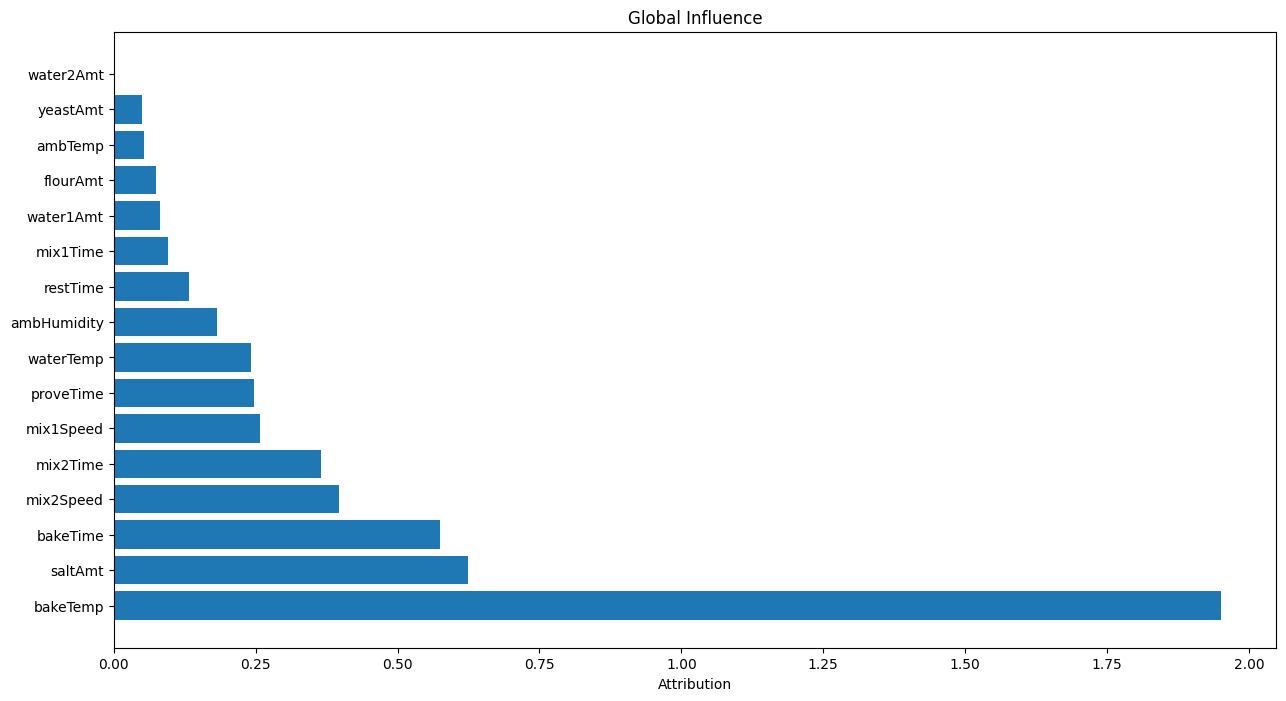

In [72]:
plt.figure(figsize=(15,8))
plt.barh(gexplain['feature'], gexplain['attribution'])
plt.title('Global Influence')
plt.xlabel('Attribution')
#plt.ylabel('Feature')
plt.show()

### Predictions With BigQuery ML (BQML)

Create a pandas dataframe with retrieved predictions for the test data (first 10 recipes) in the table using [ML.PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict):

In [73]:
query = f"""
    SELECT Recipe, JUDGE_A, predicted_JUDGE_A, JUDGE_A-predicted_JUDGE_A as Error
    FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_AUTO}`,(
        SELECT *
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe
"""
print(query)


    SELECT Recipe, JUDGE_A, predicted_JUDGE_A, JUDGE_A-predicted_JUDGE_A as Error
    FROM ML.PREDICT (MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_auto`,(
        SELECT *
        FROM `statmike-mlops-349915.feature_engineering.bread`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe



In [74]:
bq.query(query = query).to_dataframe()

Recipe  JUDGE_A  predicted_JUDGE_A      Error
0       1     67.0          78.679902 -11.679902
1       2     81.0          74.661914   6.338086
2       3     63.0          74.376793 -11.376793
3       4     76.0          76.225022  -0.225022
4       5     57.0          81.141974 -24.141974
5       6     80.0          73.833110   6.166890
6       7     71.0          78.048941  -7.048941
7       8     85.0          77.994951   7.005049
8       9     77.0          73.119925   3.880075
9      10     86.0          74.445612  11.554388

### Local Explainability - What impacted the judges rating?

Retrieve feature attribution values to interpret each features contribution to a prediction relative to the baseline prediction using [ML.EXPLAIN_PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict).

In [75]:
query = f"""
    SELECT *
    FROM ML.EXPLAIN_PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_AUTO}`,(
        SELECT *
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe
"""
print(query)


    SELECT *
    FROM ML.EXPLAIN_PREDICT (MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_auto`,(
        SELECT *
        FROM `statmike-mlops-349915.feature_engineering.bread`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe



In [76]:
explain = bq.query(query = query).to_dataframe()
explain

predicted_JUDGE_A                           top_feature_attributions  \
0          78.679902  [{'feature': 'bakeTemp', 'attribution': 2.0935...   
1          74.661914  [{'feature': 'bakeTemp', 'attribution': 1.9096...   
2          74.376793  [{'feature': 'bakeTemp', 'attribution': -3.435...   
3          76.225022  [{'feature': 'bakeTemp', 'attribution': 2.0523...   
4          81.141974  [{'feature': 'bakeTemp', 'attribution': 5.9394...   
5          73.833110  [{'feature': 'bakeTemp', 'attribution': -1.915...   
6          78.048941  [{'feature': 'bakeTemp', 'attribution': 3.8390...   
7          77.994951  [{'feature': 'mix1Time', 'attribution': 0.9434...   
8          73.119925  [{'feature': 'saltAmt', 'attribution': -1.5206...   
9          74.445612  [{'feature': 'bakeTemp', 'attribution': -0.890...   

   baseline_prediction_value  prediction_value  approximation_error  Recipe  \
0                  75.260843         78.679902                  0.0       1   
1                  75.260843         74.661914                  0.0       2   
2                  75.260843         74.376793                  0.0       3   
3                  75.260843         76.225022                  0.0       4   
4                  75.260843         81.141974                  0.0       5   
5                  75.260843         73.833110                  0.0       6   
6                  75.260843         78.048941                  0.0       7   
7                  75.260843         77.994951                  0.0       8   
8                  75.260843         73.119925                  0.0       9   
9                  75.260843         74.445612                  0.0      10   

     flourAmt  saltAmt  yeastAmt  mix1Time  ...   water2Amt  waterTemp  \
0  497.653667       10         8         6  ...  154.760677         49   
1  498.896134       11        10         5  ...  104.764913         44   
2  499.148669       10        10         4  ...  123.540921         41   
3  492.972374        9         9         6  ...  114.369975         49   
4  523.183916        9        11         4  ...   92.490886         42   
5  500.624903       10        11         6  ...  106.938983         42   
6  493.567697       10        11         6  ...  101.274937         44   
7  490.405017        9         9         3  ...  108.808548         41   
8  480.119660       12        10         4  ...  126.079875         46   
9  502.946563       10        10         6  ...   93.776765         46   

    proveTime  restTime  bakeTime    bakeTemp    ambTemp  ambHumidity  \
0   97.656789        36        28  409.798183  61.812613    24.599715   
1   98.061250        36        29  411.079681  45.124131    37.109838   
2  101.036741        38        29  448.329332  70.566656    51.204248   
3   99.773276        36        26  410.085443  69.017800    40.497711   
4  100.580615        42        27  382.998319  58.607860    62.926785   
5   95.026082        36        22  437.734810  64.187647    41.319957   
6   97.712527        37        29  397.635143  56.730291    61.849543   
7   92.016182        45        25  426.975739  52.702558    47.944960   
8  110.620973        40        22  418.849566  54.659764    55.287793   
9   88.757280        36        25  430.588852  45.287481    53.689779   

   JUDGE_A  JUDGE_B  
0     67.0     54.0  
1     81.0     72.0  
2     63.0     48.0  
3     76.0     65.0  
4     57.0     40.0  
5     80.0     71.0  
6     71.0     59.0  
7     85.0     78.0  
8     77.0     66.0  
9     86.0     78.0  

[10 rows x 24 columns]

Create a plot of feature attributions for a single prediction:

In [77]:
recipe = 1
explanation = explain.iloc[recipe-1]['top_feature_attributions']

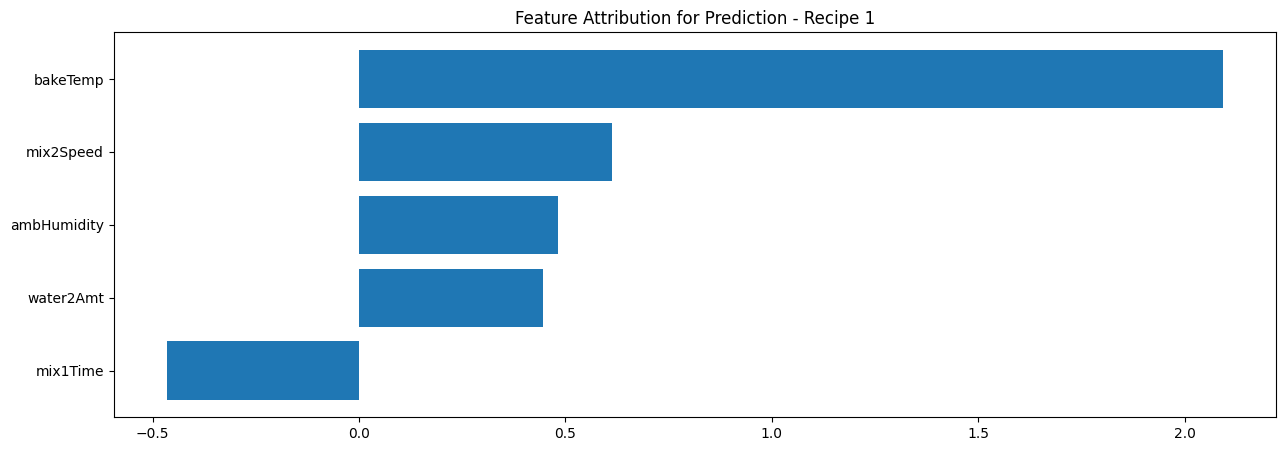

In [78]:
features = []
scores = []
for k in explanation:
    features.append(k['feature'])
    scores.append(k['attribution'])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)

plt.figure(figsize=(15,5))
plt.barh(features, scores)
plt.title(f'Feature Attribution for Prediction - Recipe {recipe}')
plt.show()

### Check out this model in the BigQuery Console:
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and dataset
- Expand Models and select the model create here

In [79]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL_AUTO}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sfeature_engineering!3s03_feature_engineering_auto


### Check out this model in the Vertex AI Console:
- Make sure project selected is the one from this notebook
- Make sure the region is `europe-west4` (default when BQ is `EU` multiregion)

In [80]:
print(f"View the model in the Vertex AI Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/bqml_{BQ_MODEL_AUTO}?project={PROJECT_ID}")

View the model in the Vertex AI Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/bqml_03_feature_engineering_auto?project=statmike-mlops-349915


## Serving

### Vertex AI Model Registry - Get Model

References:
- [aiplatform.Model()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)

In [81]:
vertex_model_auto = aiplatform.Model(model_name = f'bqml_{BQ_MODEL_AUTO}')
vertex_model_auto.resource_name

'projects/1026793852137/locations/us-central1/models/bqml_03_feature_engineering_auto'

In [82]:
evaluation_name = vertex_model_auto.get_model_evaluation().resource_name
evaluation_name

'projects/1026793852137/locations/us-central1/models/bqml_03_feature_engineering_auto@1/evaluations/2121721575165132800'

In [83]:
aiplatform.ModelEvaluation(evaluation_name = evaluation_name).to_dict()

{'name': 'projects/1026793852137/locations/us-central1/models/bqml_03_feature_engineering_auto@1/evaluations/2121721575165132800',
 'metricsSchemaUri': 'gs://google-cloud-aiplatform/schema/modelevaluation/regression_metrics_1.0.0.yaml',
 'metrics': {'meanAbsoluteError': 7.13784,
  'rSquared': 0.038250636,
  'rootMeanSquaredError': 8.947347,
  'rootMeanSquaredLogError': 0.12548275},
 'createTime': '2023-06-21T15:25:51.853707Z'}

In [84]:
vertex_model_auto.uri

### Vertex AI Endpoint - Create or Retrieve

References:
- [aiplatform.Endpoint()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint)

In [85]:
if not aiplatform.Endpoint.list(filter = f"display_name={SERIES}_{EXPERIMENT}_auto"):
    endpoint_auto = aiplatform.Endpoint.create(
        display_name = f"{SERIES}_{EXPERIMENT}_auto",
        labels = {'series' : f"{SERIES}"}
    )
    print(f"Endpoint Created: {endpoint_auto.display_name}")
else: endpoint_auto = aiplatform.Endpoint.list(filter = f"display_name={SERIES}_{EXPERIMENT}_auto")[0]

Creating Endpoint
Create Endpoint backing LRO: projects/1026793852137/locations/us-central1/endpoints/6078975489601437696/operations/5221494065048059904
Endpoint created. Resource name: projects/1026793852137/locations/us-central1/endpoints/6078975489601437696
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/1026793852137/locations/us-central1/endpoints/6078975489601437696')
Endpoint Created: 03_feature_engineering_auto


In [86]:
endpoint_auto.display_name

'03_feature_engineering_auto'

In [87]:
endpoint_auto.traffic_split

{}

In [88]:
deployed_models = endpoint_auto.list_models()
deployed_models

[]

### Deploy Model To Vertex AI Endpoint

**NOTE: This can take 15+ minutes to complete.**

In [89]:
endpoint_auto.deploy(
    model = vertex_model_auto,
    deployed_model_display_name = vertex_model_auto.display_name,
    traffic_percentage = 100,
    machine_type = 'n1-standard-2',
    min_replica_count = 1,
    max_replica_count = 1
)

Deploying Model projects/1026793852137/locations/us-central1/models/bqml_03_feature_engineering_auto to Endpoint : projects/1026793852137/locations/us-central1/endpoints/6078975489601437696
Deploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/6078975489601437696/operations/8133071224143085568
Endpoint model deployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/6078975489601437696


In [90]:
endpoint_auto.list_models()

[id: "6655847459253649408"
 model: "projects/1026793852137/locations/us-central1/models/bqml_03_feature_engineering_auto"
 display_name: "bqml_03_feature_engineering_auto"
 create_time {
   seconds: 1687361173
   nanos: 282321000
 }
 dedicated_resources {
   machine_spec {
     machine_type: "n1-standard-2"
   }
   min_replica_count: 1
   max_replica_count: 1
 }
 disable_container_logging: true
 model_version_id: "1"]

---
## Prediction

### Retrieve Records For Prediction
The first 10 recipes.

In [91]:
n = 10
pred = bq.query(
    query = f"""
        SELECT * EXCEPT(JUDGE_B)
        FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}
        WHERE Recipe <= 10
        ORDER BY Recipe
    """
).to_dataframe()

In [92]:
pred

Recipe    flourAmt  saltAmt  yeastAmt  mix1Time  mix1Speed  mix2Time  \
0       1  497.653667       10         8         6          3         6   
1       2  498.896134       11        10         5          4         5   
2       3  499.148669       10        10         4          4         7   
3       4  492.972374        9         9         6          4         4   
4       5  523.183916        9        11         4          4         5   
5       6  500.624903       10        11         6          3         7   
6       7  493.567697       10        11         6          2         5   
7       8  490.405017        9         9         3          3         7   
8       9  480.119660       12        10         4          4         5   
9      10  502.946563       10        10         6          2         7   

   mix2Speed   water1Amt   water2Amt  waterTemp   proveTime  restTime  \
0          4  320.903454  154.760677         49   97.656789        36   
1          6  294.907489  104.764913         44   98.061250        36   
2          5  358.745436  123.540921         41  101.036741        38   
3          6  347.921558  114.369975         49   99.773276        36   
4          5  329.234385   92.490886         42  100.580615        42   
5          5  320.498138  106.938983         42   95.026082        36   
6          4  330.416212  101.274937         44   97.712527        37   
7          4  370.472110  108.808548         41   92.016182        45   
8          6  332.241730  126.079875         46  110.620973        40   
9          4  348.006773   93.776765         46   88.757280        36   

   bakeTime    bakeTemp    ambTemp  ambHumidity  JUDGE_A  
0        28  409.798183  61.812613    24.599715     67.0  
1        29  411.079681  45.124131    37.109838     81.0  
2        29  448.329332  70.566656    51.204248     63.0  
3        26  410.085443  69.017800    40.497711     76.0  
4        27  382.998319  58.607860    62.926785     57.0  
5        22  437.734810  64.187647    41.319957     80.0  
6        29  397.635143  56.730291    61.849543     71.0  
7        25  426.975739  52.702558    47.944960     85.0  
8        22  418.849566  54.659764    55.287793     77.0  
9        25  430.588852  45.287481    53.689779     86.0

Shape as instances: dictionaries of key:value pairs for only features used in model

In [93]:
newobs = pred[pred.columns[~pred.columns.isin(['JUDGE_A', 'Recipe'])]].to_dict(orient='records')

In [94]:
newobs[0]

{'flourAmt': 497.65366727027174,
 'saltAmt': 10,
 'yeastAmt': 8,
 'mix1Time': 6,
 'mix1Speed': 3,
 'mix2Time': 6,
 'mix2Speed': 4,
 'water1Amt': 320.90345406268847,
 'water2Amt': 154.7606766243992,
 'waterTemp': 49,
 'proveTime': 97.65678893192006,
 'restTime': 36,
 'bakeTime': 28,
 'bakeTemp': 409.7981826922043,
 'ambTemp': 61.81261292624964,
 'ambHumidity': 24.59971473082628}

In [95]:
instances = [json_format.ParseDict(newob, Value()) for newob in newobs]

In [96]:
len(instances)

10

### Get Predictions: Python Client

In [97]:
prediction = endpoint_auto.predict(instances = instances)
prediction.predictions[0]

[78.67990162908798]

In [98]:
prediction.predictions

[[78.67990162908798],
 [74.66191438283916],
 [74.3767911755266],
 [76.22502129655959],
 [81.14197357997809],
 [73.8331107077718],
 [78.04894237542965],
 [77.99495146603634],
 [73.11992354925482],
 [74.44561362902371]]

#### Compare to BigQuery ML.PREDICT Results:

In [99]:
query = f"""
    SELECT Recipe, JUDGE_A, predicted_JUDGE_A, JUDGE_A-predicted_JUDGE_A as Error
    FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_AUTO}`,(
        SELECT *
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe
"""
bq.query(query = query).to_dataframe()

Recipe  JUDGE_A  predicted_JUDGE_A      Error
0       1     67.0          78.679902 -11.679902
1       2     81.0          74.661914   6.338086
2       3     63.0          74.376793 -11.376793
3       4     76.0          76.225022  -0.225022
4       5     57.0          81.141974 -24.141974
5       6     80.0          73.833110   6.166890
6       7     71.0          78.048941  -7.048941
7       8     85.0          77.994951   7.005049
8       9     77.0          73.119925   3.880075
9      10     86.0          74.445612  11.554388

---
# Feature Engineering With Inline TRANSFORM Clause

## Train Model

Use BigQuery ML to train a boosted tree:
- [Boosted Tree](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-boosted-tree) with BigQuery ML (BQML)

Feature preprocessing with the `TRANSFORM` clause:
- [TRANSFORM](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create#transform)

Register the model to Vertex AI Model Registry:
- `MODEL_REGISTRY` [training options](https://cloud.google.com/bigquery-ml/docs/create_vertex) to register the resulting model in the [Vertex AI Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).

In [100]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
RUN_NAME = f'run-{TIMESTAMP}'
BQ_MODEL_TRANSFORM = f'{SERIES}_{EXPERIMENT}_transform'

In [101]:
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_TRANSFORM}`
TRANSFORM (
    JUDGE_A,

    ML.MIN_MAX_SCALER(flourAmt) OVER() as scale_flourAmt, 
    ML.ROBUST_SCALER(saltAmt) OVER() as scale_saltAmt,
    ML.MAX_ABS_SCALER(yeastAmt) OVER() as scale_yeastAmt,
    ML.STANDARD_SCALER(water1Amt) OVER() as scale_water1Amt,
    ML.STANDARD_SCALER(water2Amt) OVER() as scale_water2Amt,

    ML.STANDARD_SCALER(waterTemp) OVER() as scale_waterTemp,
    ML.ROBUST_SCALER(bakeTemp) OVER() as scale_bakeTemp,
    ML.MIN_MAX_SCALER(ambTemp) OVER() as scale_ambTemp,
    ML.MAX_ABS_SCALER(ambHumidity) OVER() as scale_ambHumidity,

    ML.ROBUST_SCALER(mix1Time) OVER() as scale_mix1Time,
    ML.ROBUST_SCALER(mix2Time) OVER() as scale_mix2Time,
    ML.ROBUST_SCALER(mix1Speed) OVER() as scale_mix1Speed,
    ML.ROBUST_SCALER(mix2Speed) OVER() as scale_mix2Speed,
    ML.STANDARD_SCALER(proveTime) OVER() as scale_proveTime,
    ML.MAX_ABS_SCALER(restTime) OVER() as scale_restTime,
    ML.MAX_ABS_SCALER(bakeTime) OVER() as scale_bakeTime
)
OPTIONS (
        model_type = 'BOOSTED_TREE_REGRESSOR',
        booster_type = 'GBTREE',
        num_parallel_tree = 25,
        early_stop = TRUE,
        min_rel_progress = 0.01,
        tree_method = 'HIST',
        subsample = 0.85,
        #model_type = 'LINEAR_REG',        
        input_label_cols = ['JUDGE_A'],
        enable_global_explain = TRUE,
        data_split_method = 'AUTO_SPLIT',
        l1_reg = 10,
        l2_reg = 10,
        MODEL_REGISTRY = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'bqml_{BQ_MODEL_TRANSFORM}',
        VERTEX_AI_MODEL_VERSION_ALIASES = ['{RUN_NAME}']
    ) AS
SELECT * EXCEPT(Recipe, JUDGE_B)
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""
print(query)


CREATE OR REPLACE MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_transform`
TRANSFORM (
    JUDGE_A,

    ML.MIN_MAX_SCALER(flourAmt) OVER() as scale_flourAmt, 
    ML.ROBUST_SCALER(saltAmt) OVER() as scale_saltAmt,
    ML.MAX_ABS_SCALER(yeastAmt) OVER() as scale_yeastAmt,
    ML.STANDARD_SCALER(water1Amt) OVER() as scale_water1Amt,
    ML.STANDARD_SCALER(water2Amt) OVER() as scale_water2Amt,

    ML.STANDARD_SCALER(waterTemp) OVER() as scale_waterTemp,
    ML.ROBUST_SCALER(bakeTemp) OVER() as scale_bakeTemp,
    ML.MIN_MAX_SCALER(ambTemp) OVER() as scale_ambTemp,
    ML.MAX_ABS_SCALER(ambHumidity) OVER() as scale_ambHumidity,

    ML.ROBUST_SCALER(mix1Time) OVER() as scale_mix1Time,
    ML.ROBUST_SCALER(mix2Time) OVER() as scale_mix2Time,
    ML.ROBUST_SCALER(mix1Speed) OVER() as scale_mix1Speed,
    ML.ROBUST_SCALER(mix2Speed) OVER() as scale_mix2Speed,
    ML.STANDARD_SCALER(proveTime) OVER() as scale_proveTime,
    ML.MAX_ABS_SCALER(restTime) OVER() as sca

In [102]:
job = bq.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

526.269

In [103]:
job.total_bytes_processed

34725941734

Add labels to the model in BigQuery:

In [104]:
bqml_model_transform = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_TRANSFORM}')
bqml_model_transform.labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
bqml_model_transform = bq.update_model(bqml_model_transform, ['labels'])

### Feature and Training Review

Review the Model Inputs, the feature information before preprocessing, with [ML.FEATURE_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature):

In [105]:
query = f"""
    SELECT *
    FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_TRANSFORM}`)
"""
print(query)


    SELECT *
    FROM ML.FEATURE_INFO(MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_transform`)



In [106]:
bq.query(query = query).to_dataframe()

input         min         max        mean      median     stddev  \
0   ambHumidity   17.222334   84.174949   50.194717   50.218754  10.180430   
1     water2Amt   47.718380  185.141560  110.403007  110.571710  19.812930   
2       ambTemp   26.519930   98.676478   59.892889   59.831760   9.960117   
3     mix2Speed    4.000000    6.000000    5.002460    5.000000   0.710359   
4       saltAmt    8.000000   12.000000   10.011070   10.000000   1.216249   
5     proveTime   84.356559  116.873081   99.829747   99.881445   5.003812   
6      mix2Time    4.000000    8.000000    6.007995    6.000000   1.218043   
7      bakeTemp  372.216319  494.115652  424.733760  424.389160  15.242977   
8     mix1Speed    2.000000    5.000000    3.486470    3.000000   0.962753   
9      bakeTime   20.000000   30.000000   24.951415   25.000000   2.916390   
10     restTime   35.000000   45.000000   40.047970   40.000000   2.913339   
11     mix1Time    1.000000    8.000000    4.960640    5.000000   1.038781   
12    water1Amt  259.620480  399.383905  330.081220  329.895510  20.398010   
13    waterTemp   40.000000   50.000000   45.075031   45.000000   2.946586   
14     flourAmt  467.532072  532.904104  500.065263  500.194130  10.294796   
15     yeastAmt    8.000000   12.000000    9.987700   10.000000   1.224809   

    category_count  null_count  dimension  
0             <NA>           0       <NA>  
1             <NA>           0       <NA>  
2             <NA>           0       <NA>  
3             <NA>           0       <NA>  
4             <NA>           0       <NA>  
5             <NA>           0       <NA>  
6             <NA>           0       <NA>  
7             <NA>           0       <NA>  
8             <NA>           0       <NA>  
9             <NA>           0       <NA>  
10            <NA>           0       <NA>  
11            <NA>           0       <NA>  
12            <NA>           0       <NA>  
13            <NA>           0       <NA>  
14            <NA>           0       <NA>  
15            <NA>           0       <NA>

Review the iterations from training with [ML.TRAINING_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train):

In [107]:
query = f"""
    SELECT *
    FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_TRANSFORM}`)
    ORDER BY iteration
"""
print(query)


    SELECT *
    FROM ML.TRAINING_INFO(MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_transform`)
    ORDER BY iteration



In [108]:
history = bq.query(query = query).to_dataframe()
history

training_run  iteration      loss  eval_loss  learning_rate  duration_ms
0              0          1  52.93630   52.08400            0.3        91951
1              0          2  37.64060   36.84880            0.3           69
2              0          3  26.93830   26.15150            0.3           78
3              0          4  19.48630   18.76980            0.3           62
4              0          5  14.27190   13.61350            0.3           64
5              0          6  10.63340   10.20000            0.3           59
6              0          7   8.10675    7.90415            0.3           69
7              0          8   6.34967    6.35560            0.3        15370
8              0          9   5.10065    5.34130            0.3          158
9              0         10   4.21729    4.66780            0.3           78
10             0         11   3.60071    4.25600            0.3           70
11             0         12   3.15829    3.99687            0.3           62
12             0         13   2.81318    3.80329            0.3           70
13             0         14   2.55872    3.66749            0.3           56
14             0         15   2.35877    3.57206            0.3           63
15             0         16   2.18094    3.48250            0.3           58
16             0         17   2.04538    3.42015            0.3           51
17             0         18   1.92583    3.36835            0.3           72
18             0         19   1.81630    3.30818            0.3           95
19             0         20   1.72170    3.26053            0.3           63

Plot the loss history:

<AxesSubplot:xlabel='iteration'>

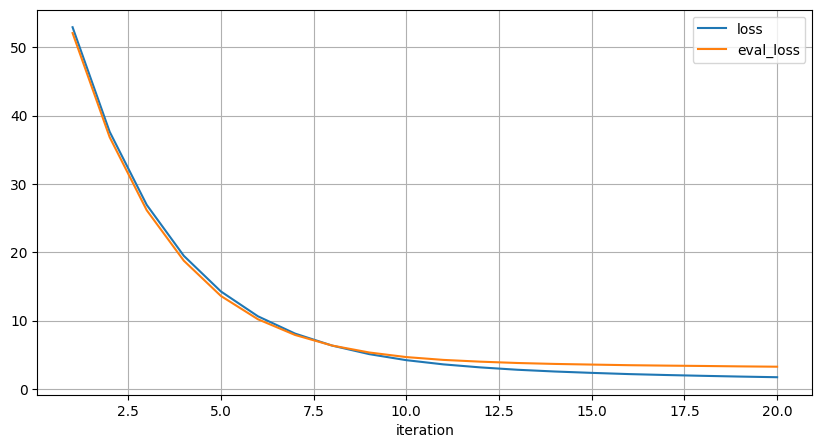

In [109]:
history.plot(x = 'iteration', y = ['loss','eval_loss'], figsize = (10, 5), grid = True)

### Model Metrics Review

Review the model evaluation statistics with [ML.EVALUATE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate):

In [110]:
query = f"""
    SELECT * FROM ML.EVALUATE(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_TRANSFORM}`)
"""
print(query)


    SELECT * FROM ML.EVALUATE(MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_transform`)



In [111]:
bq.query(query = query).to_dataframe()

mean_absolute_error  mean_squared_error  mean_squared_log_error  \
0              2.36459            9.331377                0.002274   

   median_absolute_error  r2_score  explained_variance  
0               2.006508  0.912498            0.912733

### Comparing Metrics Between Automatic and Manual Feature Engineering

The query here loads the metrics with `ML.EVALUATE` for both models.

In [112]:
query = f"""
    SELECT 'Automatic Feature Engineering' as Approach, * FROM ML.EVALUATE(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_AUTO}`)
    UNION ALL
    SELECT 'Feature Engineering With Inline TRANSFORM' as Approach, * FROM ML.EVALUATE(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_TRANSFORM}`)
"""
print(query)


    SELECT 'Automatic Feature Engineering' as Approach, * FROM ML.EVALUATE(MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_auto`)
    UNION ALL
    SELECT 'Feature Engineering With Inline TRANSFORM' as Approach, * FROM ML.EVALUATE(MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_transform`)



In [113]:
bq.query(query = query).to_dataframe()

Approach  mean_absolute_error  \
0              Automatic Feature Engineering             7.526567   
1  Feature Engineering With Inline TRANSFORM             2.364590   

   mean_squared_error  mean_squared_log_error  median_absolute_error  \
0           97.032748                0.022136               5.894421   
1            9.331377                0.002274               2.006508   

   r2_score  explained_variance  
0  0.090110            0.097917  
1  0.912498            0.912733

The results show a vast improvement in all metrics.  This is mostly because the relationship between the features and the target was created to have covariance that is best explained by higher order terms.  Fitting the model with a non-linear approach, like a boosted tree (`model_type = BOOSTED_TREE_REGRESSOR`), would also better understand the relationships in these data.

### Feature Importance

Retrieve the [XGBoost feature importances](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor.feature_importances_) for the model using [ML.FEATURE_IMPORTANCE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-importance).
- importance_weight: the number of splits the feature was used in across all trees
- importance_gain: the improvement in accuracy due to splits using the feature
- importance_cover: the number of rows of data covered by splits using the feature

In [114]:
query = f"""
    SELECT *
    FROM ML.FEATURE_IMPORTANCE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_TRANSFORM}`)
    ORDER BY importance_gain DESC
"""
print(query)


    SELECT *
    FROM ML.FEATURE_IMPORTANCE (MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_transform`)
    ORDER BY importance_gain DESC



In [115]:
feature_importance = bq.query(query = query).to_dataframe()
feature_importance

feature  importance_weight  importance_gain  importance_cover
0      scale_bakeTemp               2774       565.958815        308.468277
1     scale_water2Amt               2277       205.693715        259.554238
2      scale_bakeTime               1471       113.281676        222.191706
3      scale_mix2Time                590       102.079359        309.216949
4      scale_yeastAmt                898        99.044694        325.025612
5      scale_mix1Time                866        68.420530        260.724018
6      scale_flourAmt               2092        65.833616        183.228489
7     scale_mix2Speed                302        50.512393        331.519868
8       scale_saltAmt                615        30.528416        137.941463
9      scale_restTime                763        27.537822        150.585845
10    scale_water1Amt               1080        20.482882         89.902778
11      scale_ambTemp               1066        11.499930         57.113508
12  scale_ambHumidity               1026         9.193458         61.961014
13    scale_proveTime                930         9.165004         55.460215
14    scale_mix1Speed                185         7.272201         42.902703
15    scale_waterTemp                416         5.390591         39.983173

### Global Explainability - What is important to Judges?

Retrieve the influence of each feature on the model with [ML.GLOBAL_EXPLAIN](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-global-explain).  

In [116]:
query = f"""
    SELECT *
    FROM ML.GLOBAL_EXPLAIN (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_TRANSFORM}`)
"""
print(query)


    SELECT *
    FROM ML.GLOBAL_EXPLAIN (MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_transform`)



In [117]:
gexplain = bq.query(query = query).to_dataframe()
gexplain

feature  attribution
0      scale_bakeTemp     6.277062
1     scale_water2Amt     2.595406
2      scale_bakeTime     1.114984
3      scale_flourAmt     1.004529
4      scale_mix2Time     0.695363
5      scale_yeastAmt     0.691773
6      scale_mix1Time     0.450873
7     scale_mix2Speed     0.237933
8       scale_saltAmt     0.196091
9      scale_restTime     0.186976
10    scale_water1Amt     0.129547
11  scale_ambHumidity     0.029788
12      scale_ambTemp     0.029665
13    scale_proveTime     0.027835
14    scale_waterTemp     0.009000
15    scale_mix1Speed     0.007191

Plot the attribution:

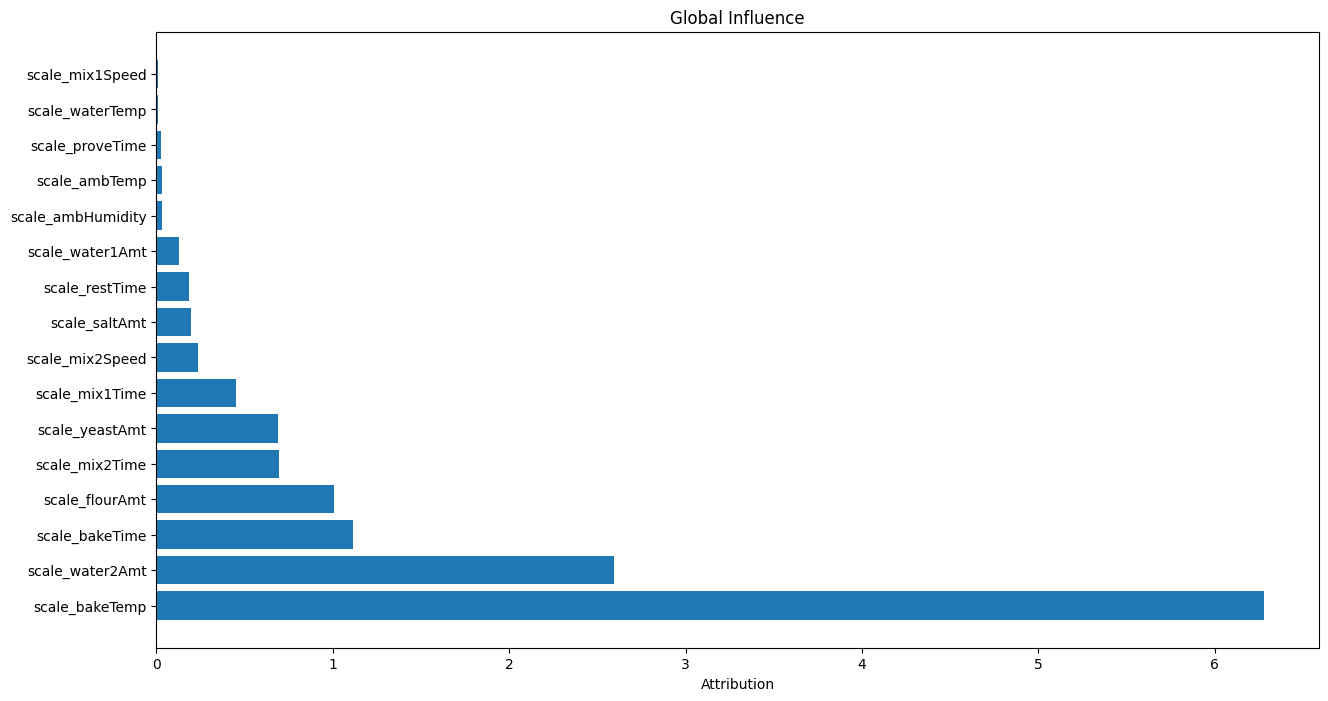

In [118]:
plt.figure(figsize=(15,8))
plt.barh(gexplain['feature'], gexplain['attribution'])
plt.title('Global Influence')
plt.xlabel('Attribution')
#plt.ylabel('Feature')
plt.show()

### Predictions With BigQuery ML (BQML)

Create a pandas dataframe with retrieved predictions for the test data in the table using [ML.PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict):

In [119]:
query = f"""
    SELECT Recipe, JUDGE_A, predicted_JUDGE_A, JUDGE_A-predicted_JUDGE_A as Error
    FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_TRANSFORM}`,(
        SELECT *
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe
"""
print(query)


    SELECT Recipe, JUDGE_A, predicted_JUDGE_A, JUDGE_A-predicted_JUDGE_A as Error
    FROM ML.PREDICT (MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_transform`,(
        SELECT *
        FROM `statmike-mlops-349915.feature_engineering.bread`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe



In [120]:
bq.query(query = query).to_dataframe()

Recipe  JUDGE_A  predicted_JUDGE_A     Error
0       1     67.0          67.211510 -0.211510
1       2     81.0          80.786530  0.213470
2       3     63.0          62.556980  0.443020
3       4     76.0          77.471687 -1.471687
4       5     57.0          56.580448  0.419552
5       6     80.0          79.489357  0.510643
6       7     71.0          69.679268  1.320732
7       8     85.0          85.045792 -0.045792
8       9     77.0          76.978699  0.021301
9      10     86.0          84.083557  1.916443

### Local Explainability - What impacted the judges rating?

Retrieve feature attribution values to interpret each features contribution to a prediction relative to the baseline prediction using [ML.EXPLAIN_PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict).

In [121]:
query = f"""
    SELECT *
    FROM ML.EXPLAIN_PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_TRANSFORM}`,(
        SELECT *
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe
"""
print(query)


    SELECT *
    FROM ML.EXPLAIN_PREDICT (MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_transform`,(
        SELECT *
        FROM `statmike-mlops-349915.feature_engineering.bread`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe



In [122]:
explain = bq.query(query = query).to_dataframe()
explain

predicted_JUDGE_A                           top_feature_attributions  \
0          67.211510  [{'feature': 'scale_water2Amt', 'attribution':...   
1          80.786530  [{'feature': 'scale_water2Amt', 'attribution':...   
2          62.556980  [{'feature': 'scale_bakeTemp', 'attribution': ...   
3          77.471687  [{'feature': 'scale_water2Amt', 'attribution':...   
4          56.580448  [{'feature': 'scale_bakeTemp', 'attribution': ...   
5          79.489357  [{'feature': 'scale_water2Amt', 'attribution':...   
6          69.679268  [{'feature': 'scale_bakeTemp', 'attribution': ...   
7          85.045792  [{'feature': 'scale_bakeTemp', 'attribution': ...   
8          76.978699  [{'feature': 'scale_bakeTemp', 'attribution': ...   
9          84.083557  [{'feature': 'scale_bakeTemp', 'attribution': ...   

   baseline_prediction_value  prediction_value  approximation_error  Recipe  \
0                  75.191727         67.211550                  0.0       1   
1                  75.191727         80.786562                  0.0       2   
2                  75.191727         62.556991                  0.0       3   
3                  75.191727         77.471702                  0.0       4   
4                  75.191727         56.580460                  0.0       5   
5                  75.191727         79.489419                  0.0       6   
6                  75.191727         69.679249                  0.0       7   
7                  75.191727         85.045769                  0.0       8   
8                  75.191727         76.978752                  0.0       9   
9                  75.191727         84.083557                  0.0      10   

     flourAmt  saltAmt  yeastAmt  mix1Time  ...   water2Amt  waterTemp  \
0  497.653667       10         8         6  ...  154.760677         49   
1  498.896134       11        10         5  ...  104.764913         44   
2  499.148669       10        10         4  ...  123.540921         41   
3  492.972374        9         9         6  ...  114.369975         49   
4  523.183916        9        11         4  ...   92.490886         42   
5  500.624903       10        11         6  ...  106.938983         42   
6  493.567697       10        11         6  ...  101.274937         44   
7  490.405017        9         9         3  ...  108.808548         41   
8  480.119660       12        10         4  ...  126.079875         46   
9  502.946563       10        10         6  ...   93.776765         46   

    proveTime  restTime  bakeTime    bakeTemp    ambTemp  ambHumidity  \
0   97.656789        36        28  409.798183  61.812613    24.599715   
1   98.061250        36        29  411.079681  45.124131    37.109838   
2  101.036741        38        29  448.329332  70.566656    51.204248   
3   99.773276        36        26  410.085443  69.017800    40.497711   
4  100.580615        42        27  382.998319  58.607860    62.926785   
5   95.026082        36        22  437.734810  64.187647    41.319957   
6   97.712527        37        29  397.635143  56.730291    61.849543   
7   92.016182        45        25  426.975739  52.702558    47.944960   
8  110.620973        40        22  418.849566  54.659764    55.287793   
9   88.757280        36        25  430.588852  45.287481    53.689779   

   JUDGE_A  JUDGE_B  
0     67.0     54.0  
1     81.0     72.0  
2     63.0     48.0  
3     76.0     65.0  
4     57.0     40.0  
5     80.0     71.0  
6     71.0     59.0  
7     85.0     78.0  
8     77.0     66.0  
9     86.0     78.0  

[10 rows x 24 columns]

Create a plot of feature attributions for a single prediction:

In [123]:
recipe = 1
explanation = explain.iloc[recipe-1]['top_feature_attributions']

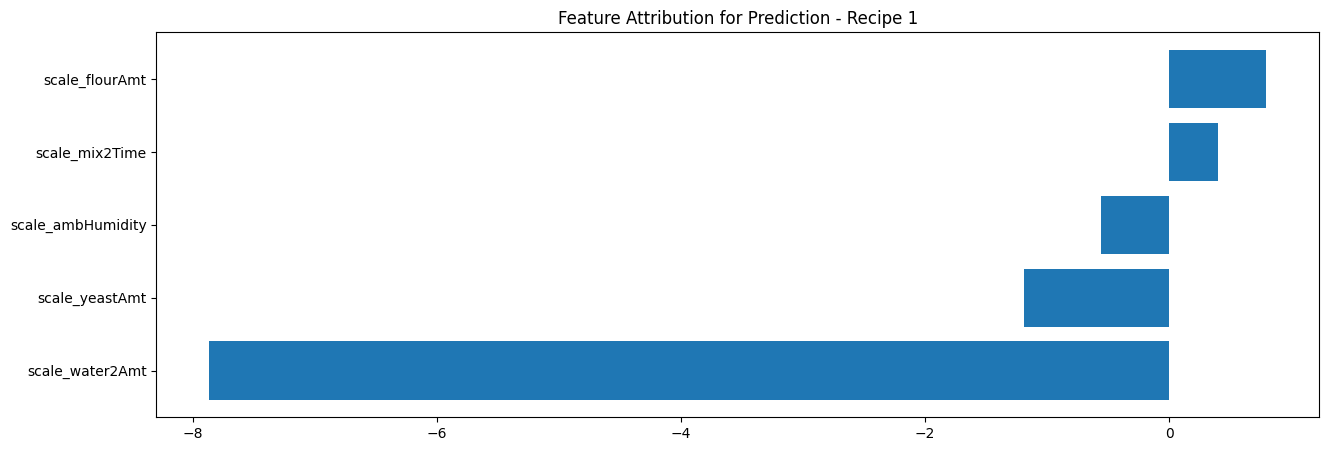

In [124]:
features = []
scores = []
for k in explanation:
    features.append(k['feature'])
    scores.append(k['attribution'])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)

plt.figure(figsize=(15,5))
plt.barh(features, scores)
plt.title(f'Feature Attribution for Prediction - Recipe {recipe}')
plt.show()

### Check out this model in the BigQuery Console:
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and dataset
- Expand Models and select the model create here

In [125]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL_TRANSFORM}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sfeature_engineering!3s03_feature_engineering_transform


### Check out this model in the Vertex AI Console:
- Make sure project selected is the one from this notebook
- Make sure the region is `europe-west4` (default when BQ is `EU` multiregion)

In [126]:
print(f"View the model in the Vertex AI Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/bqml_{BQ_MODEL_TRANSFORM}?project={PROJECT_ID}")

View the model in the Vertex AI Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/bqml_03_feature_engineering_transform?project=statmike-mlops-349915


---
## Serving

**Notes on Serving With Manual Feature Engineering**

When this model was trained it also registered to Vertex AI Model Registry.  With the inline TRANSFORM statement the resulting model is also directly servable even though it is actually 2 models, a preprocessing model that represents the `TRANSFORM` clause, and a model that serves responses from the inputs shaped by the preprocessing.  When deployed the models and pipelined together on the same endpoint.  As long as the `TRANSFORM` statement used [suppored SQL functions](https://cloud.google.com/bigquery/docs/exporting-models#export-transform-functions) this will works.

### Vertex AI Model Registry - Get Models

When these modes were trained in BigQuery ML they included options for registration in Vertex AI Model Registry.  This section shows how to retrieve the information from the model unsing Vetex AI.

References:
- [aiplatform.Model()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)

In [127]:
vertex_model_transform = aiplatform.Model(model_name = f'bqml_{BQ_MODEL_TRANSFORM}')
vertex_model_transform.resource_name

'projects/1026793852137/locations/us-central1/models/bqml_03_feature_engineering_transform'

In [128]:
aiplatform.ModelEvaluation(
    evaluation_name = vertex_model_transform.get_model_evaluation().resource_name
).to_dict()

{'name': 'projects/1026793852137/locations/us-central1/models/bqml_03_feature_engineering_transform@1/evaluations/2800797548665634816',
 'metricsSchemaUri': 'gs://google-cloud-aiplatform/schema/modelevaluation/regression_metrics_1.0.0.yaml',
 'metrics': {'rootMeanSquaredLogError': 0.038172837,
  'rSquared': 0.9133922,
  'meanAbsoluteError': 2.0918958,
  'rootMeanSquaredError': 2.684985},
 'createTime': '2023-06-21T15:47:53.965520Z'}

In [129]:
# note: this is blank since the model is in two parts which are managed in a single container at deployment, see export below:
vertex_model_transform.uri 

### Vertex AI Endpoint - Create or Retrieve

References:
- [aiplatform.Endpoint()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint)

In [130]:
if not aiplatform.Endpoint.list(filter = f"display_name={SERIES}_{EXPERIMENT}_transform"):
    endpoint_transform = aiplatform.Endpoint.create(
        display_name = f"{SERIES}_{EXPERIMENT}_transform",
        labels = {'series' : f"{SERIES}"}
    )
    print(f"Endpoint Created: {endpoint_transform.display_name}")
else: endpoint_transform = aiplatform.Endpoint.list(filter = f"display_name={SERIES}_{EXPERIMENT}_transform")[0]

Creating Endpoint
Create Endpoint backing LRO: projects/1026793852137/locations/us-central1/endpoints/5391613596474015744/operations/6782835760862068736
Endpoint created. Resource name: projects/1026793852137/locations/us-central1/endpoints/5391613596474015744
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/1026793852137/locations/us-central1/endpoints/5391613596474015744')
Endpoint Created: 03_feature_engineering_auto


In [131]:
endpoint_transform.display_name

'03_feature_engineering_transform'

In [132]:
endpoint_transform.traffic_split

{}

In [133]:
deployed_models = endpoint_transform.list_models()
deployed_models

[]

### Deploy Model To Vertex AI Endpoint

**NOTE: This can take 15+ minutes to complete.**

In [134]:
endpoint_transform.deploy(
    model = vertex_model_transform,
    deployed_model_display_name = vertex_model_transform.display_name,
    traffic_percentage = 100,
    machine_type = 'n1-standard-2',
    min_replica_count = 1,
    max_replica_count = 1
)

Deploying Model projects/1026793852137/locations/us-central1/models/bqml_03_feature_engineering_transform to Endpoint : projects/1026793852137/locations/us-central1/endpoints/5391613596474015744
Deploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/5391613596474015744/operations/2036041753613565952
Endpoint model deployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/5391613596474015744


In [135]:
endpoint_transform.list_models()

[id: "2488891904029097984"
 model: "projects/1026793852137/locations/us-central1/models/bqml_03_feature_engineering_transform"
 display_name: "bqml_03_feature_engineering_transform"
 create_time {
   seconds: 1687362493
   nanos: 237560000
 }
 dedicated_resources {
   machine_spec {
     machine_type: "n1-standard-2"
   }
   min_replica_count: 1
   max_replica_count: 1
 }
 explanation_spec {
   parameters {
     sampled_shapley_attribution {
       path_count: 5
     }
   }
   metadata {
     inputs {
       key: "ambHumidity"
       value {
       }
     }
     inputs {
       key: "ambTemp"
       value {
       }
     }
     inputs {
       key: "bakeTemp"
       value {
       }
     }
     inputs {
       key: "bakeTime"
       value {
       }
     }
     inputs {
       key: "flourAmt"
       value {
       }
     }
     inputs {
       key: "mix1Speed"
       value {
       }
     }
     inputs {
       key: "mix1Time"
       value {
       }
     }
     inputs {
       key: "m

---
## Prediction

### Retrieve Records For Prediction
The first 10 recipes.

In [136]:
n = 10
pred = bq.query(
    query = f"""
        SELECT * EXCEPT(JUDGE_B)
        FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}
        WHERE Recipe <= 10
        ORDER BY Recipe
    """
).to_dataframe()

In [137]:
pred

Recipe    flourAmt  saltAmt  yeastAmt  mix1Time  mix1Speed  mix2Time  \
0       1  497.653667       10         8         6          3         6   
1       2  498.896134       11        10         5          4         5   
2       3  499.148669       10        10         4          4         7   
3       4  492.972374        9         9         6          4         4   
4       5  523.183916        9        11         4          4         5   
5       6  500.624903       10        11         6          3         7   
6       7  493.567697       10        11         6          2         5   
7       8  490.405017        9         9         3          3         7   
8       9  480.119660       12        10         4          4         5   
9      10  502.946563       10        10         6          2         7   

   mix2Speed   water1Amt   water2Amt  waterTemp   proveTime  restTime  \
0          4  320.903454  154.760677         49   97.656789        36   
1          6  294.907489  104.764913         44   98.061250        36   
2          5  358.745436  123.540921         41  101.036741        38   
3          6  347.921558  114.369975         49   99.773276        36   
4          5  329.234385   92.490886         42  100.580615        42   
5          5  320.498138  106.938983         42   95.026082        36   
6          4  330.416212  101.274937         44   97.712527        37   
7          4  370.472110  108.808548         41   92.016182        45   
8          6  332.241730  126.079875         46  110.620973        40   
9          4  348.006773   93.776765         46   88.757280        36   

   bakeTime    bakeTemp    ambTemp  ambHumidity  JUDGE_A  
0        28  409.798183  61.812613    24.599715     67.0  
1        29  411.079681  45.124131    37.109838     81.0  
2        29  448.329332  70.566656    51.204248     63.0  
3        26  410.085443  69.017800    40.497711     76.0  
4        27  382.998319  58.607860    62.926785     57.0  
5        22  437.734810  64.187647    41.319957     80.0  
6        29  397.635143  56.730291    61.849543     71.0  
7        25  426.975739  52.702558    47.944960     85.0  
8        22  418.849566  54.659764    55.287793     77.0  
9        25  430.588852  45.287481    53.689779     86.0

Shape as instances: dictionaries of key:value pairs for only features used in model

In [138]:
newobs = pred[pred.columns[~pred.columns.isin(['JUDGE_A', 'Recipe'])]].to_dict(orient='records')

In [139]:
newobs[0]

{'flourAmt': 497.65366727027174,
 'saltAmt': 10,
 'yeastAmt': 8,
 'mix1Time': 6,
 'mix1Speed': 3,
 'mix2Time': 6,
 'mix2Speed': 4,
 'water1Amt': 320.90345406268847,
 'water2Amt': 154.7606766243992,
 'waterTemp': 49,
 'proveTime': 97.65678893192006,
 'restTime': 36,
 'bakeTime': 28,
 'bakeTemp': 409.7981826922043,
 'ambTemp': 61.81261292624964,
 'ambHumidity': 24.59971473082628}

In [140]:
instances = [json_format.ParseDict(newob, Value()) for newob in newobs]

In [141]:
len(instances)

10

### Get Predictions: Python Client

In [142]:
prediction = endpoint_transform.predict(instances = instances)
prediction.predictions[0]

67.21149444580078

In [143]:
prediction.predictions

[67.21149444580078,
 80.78654479980469,
 62.55698013305664,
 77.47169494628906,
 56.58044815063477,
 79.4893569946289,
 69.67926788330078,
 85.04579162597656,
 76.97869873046875,
 84.08355712890625]

#### Compare to BigQuery ML.PREDICT Results:

In [146]:
query = f"""
    SELECT Recipe, JUDGE_A, predicted_JUDGE_A, JUDGE_A-predicted_JUDGE_A as Error
    FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_TRANSFORM}`,(
        SELECT *
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe
"""
bq.query(query = query).to_dataframe()

Recipe  JUDGE_A  predicted_JUDGE_A     Error
0       1     67.0          67.211510 -0.211510
1       2     81.0          80.786530  0.213470
2       3     63.0          62.556980  0.443020
3       4     76.0          77.471687 -1.471687
4       5     57.0          56.580448  0.419552
5       6     80.0          79.489357  0.510643
6       7     71.0          69.679268  1.320732
7       8     85.0          85.045792 -0.045792
8       9     77.0          76.978699  0.021301
9      10     86.0          84.083557  1.916443

---
# Model Exports



### Manually export models from BigQuery

The models trained in BQML can be exported from BigQuery to GCS:

- [Exporting Models](https://cloud.google.com/bigquery-ml/docs/exporting-models)


In [158]:
BUCKET = f'{PROJECT_ID}-{REGION}-bqml-exports'

In [159]:
if not gcs.lookup_bucket(BUCKET):
    bucketDef = gcs.bucket(BUCKET)
    bucketDef = gcs.create_bucket(bucketDef, project=PROJECT_ID, location=REGION)
    print(f'Created Bucket: {gcs.lookup_bucket(BUCKET).name}')
else:
    bucketDef = gcs.bucket(BUCKET)
    print(f'Bucket already exist: {bucketDef.name}')

Created Bucket: statmike-mlops-349915-us-central1-bqml-exports


In [160]:
print(f'Review the storage bucket in the console here:\nhttps://console.cloud.google.com/storage/browser/{BUCKET};tab=objects&project={PROJECT_ID}')

Review the storage bucket in the console here:
https://console.cloud.google.com/storage/browser/statmike-mlops-349915-us-central1-bqml-exports;tab=objects&project=statmike-mlops-349915


In [ ]:
query = f"""
    EXPORT MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_AUTO}`
        OPTIONS (URI = 'gs://{BUCKET}/{SERIES}/auto/model');
    EXPORT MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_TRANSFORM}`
        OPTIONS (URI = 'gs://{BUCKET}/{SERIES}/transform/model');
"""
print(query)

In [162]:
export = bq.query(query = query)
export.result()
(export.ended - export.started).total_seconds()

74.442

In [ ]:
list(bucketDef.list_blobs(prefix = f'{SERIES}'))

**Observe**

The model with a `TRANSFORM` clause has a `/model` folder as well as a `/model/transform` that each contain a model save file.  

In [164]:
print(f'Review the models in the storage bucket with the console here:\nhttps://console.cloud.google.com/storage/browser/{BUCKET}/{SERIES};tab=objects&project={PROJECT_ID}')

Review the models in the storage bucket with the console here:
https://console.cloud.google.com/storage/browser/statmike-mlops-349915-us-central1-bqml-exports/03;tab=objects&project=statmike-mlops-349915


---
# Remove Resources
It is important to remove the resources created for this demonstration to prevent ongoing cost associated with storage (GCS, BigQuery) and Vertex AI Endpoints.  The code below removes all the resources created by this notebook.
- gcs bucket delete (contains model exports)
- endpoints (need to undeploy any models in use)
- bq_model (delete these first, before the dataset.  This also removes them from Vertex AI)
- bq_dataset

In [ ]:
# delete gcs bucket
bucketDef.delete(force = True)

In [ ]:
# delete endpoint, use `force` incase models are deployed or undeploy them first
endpoint_auto.delete(force = True)
endpoint_transform.delete(force = True)

In [182]:
# delete models created in BQ with BQML - this also removes them from Vertex AI Model Registry
bq.delete_model(bqml_model_auto)
bq.delete_model(bqml_model_transform)
bq.delete_model(bqml_model_transform_only)

In [183]:
# remove the BQ dataset created for this notebook
bq.delete_dataset(ds, delete_contents = True)